# Modeling of NMR-Derived Porosity using Basic Log Curves and Machine Learning
Basic porosity logs delivered from the quad-combo (DPHI, NPHI, SPHI) perform poorly in complex lithologies of many tight reserviors. NMR-Derived T2 porosities have shown much better correlation to laboratory measured core values, and is often considered the "gold standard" for open-hole derived total-porosity curves. The purpose of the code below is to employ and test various machine learning algorithms to model NMR-Derived Porosity (T2 Porosity, ie. T2PTOT) using a basic quad-combo suite with spectral GR. 

Data Source:  University 43-15, Reagan County Texas (http://utlands.utsystem.edu/API/42383373930)
Geologic Formations Logged:  Upper Spraberry-Lower Wolfcamp

Note: Mineralogic volume models were calibrated to GEM mineralogic curves.  No rock data (XRD, pyrolysis) was available to further tune models (use deterministic algebraic models at your own risk!)

Methods of Analysis:
    1.  Import LAS Files using lasio library, and merge to single dataframe
    2.  Perform inital data cleaning and processing of nulls
    3.  Quad-combo visualization
    4.  Creation of deterministic mineralogical model and basic facies model (categorial variables)
    5.  Machine Learning Input Data exploration and visualization
    6.  Creation and testing of ML models (OLS, LASSO, Ridge, ElasticNet, KNN-neighbors, Random Forest, Gradient Boost)
    7.  Tuning of Random Forest model
    8.  Final comparison and model selection

# 1.  Import LAS Files using lasio library

In [1]:
import lasio
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.linear_model import  LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.axes_grid1 import make_axes_locatable



# import LAS files
mril = lasio.read(r"C:\Users\17204\Desktop\Thinkful\Capstone 2_Supervised Machine Learning\4238337393_UNIV_43_15_1H_Mril.las")
tcombo = lasio.read(r"C:\Users\17204\Desktop\Thinkful\Capstone 2_Supervised Machine Learning\4238337393_UNIV_43_15_1H_OH.las")
dipole = lasio.read(r"C:\Users\17204\Desktop\Thinkful\Capstone 2_Supervised Machine Learning\4238337393_UNIV_43_15_1H_Wave_Anisotropy.las")
gem = lasio.read(r"C:\Users\17204\Desktop\Thinkful\Capstone 2_Supervised Machine Learning\4238337393_UNIV_43_15_1H_GEM.las")

# create dataframe for each LAS file
df_mril= mril.df()
df_tcombo = tcombo.df()
df_dipole = dipole.df()
df_gem = gem.df()

# define columns to merge which are not already present
cols_to_use = df_tcombo.columns.difference(df_mril.columns)

# merge tcombo to mril
df_all = pd.merge(df_mril, df_tcombo[cols_to_use], on = 'DEPT', how = 'inner')

# define columns to merge which are not already present
cols_to_use = df_dipole.columns.difference(df_all.columns)

# merge dipole to previous merge
df_all = pd.merge(df_all, df_dipole[cols_to_use], on = 'DEPT', how = 'inner')

# define columns to merge which are not already present
cols_to_use = df_gem.columns.difference(df_all.columns)

# merge dipole to previous merge
df_all = pd.merge(df_all, df_gem[cols_to_use], on = 'DEPT', how = 'inner')

df_all.info()

Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


<class 'pandas.core.frame.DataFrame'>
Float64Index: 6901 entries, 5490.0 to 8940.0
Data columns (total 98 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FPRES                     6901 non-null   float64
 1   FTEMP                     6901 non-null   float64
 2   GR                        6821 non-null   float64
 3   MBVIT1                    6901 non-null   float64
 4   MCBWT1                    6901 non-null   float64
 5   MPHIT1                    6901 non-null   float64
 6   MSIGT1                    6901 non-null   float64
 7   T1KCOAT                   6901 non-null   float64
 8   T1PIRRMX                  6901 non-null   float64
 9   T1PMIC                    6901 non-null   float64
 10  T1PTOT                    6901 non-null   float64
 11  T2KCOAT                   6901 non-null   float64
 12  T2PIRRMX                  6901 non-null   float64
 13  T2PMIC                    6901 non-null   float64
 14 

# 2. Intial data cleaning and dealing with nulls

In [2]:
# set index
df_all['DEPT'] = df_all.index

# replace LAS nulls with "NaN"
df_all=df_all.replace('-999.2500',np.nan)

In [3]:
# Drop columns with high null values
df_all = df_all.drop(columns= ["SWT", "WASHOUT", "VPVS","COAL", "AROSE", "AROSE180", "UNKNOWN"])

In [4]:
pd.options.display.max_rows = None
pd.set_option('display.max_columns',50)

# Find percent of missing data for each column

print(df_all.isnull().sum()*100/df_all.isnull().count())

FPRES                        0.000000
FTEMP                        0.000000
GR                           1.159252
MBVIT1                       0.000000
MCBWT1                       0.000000
MPHIT1                       0.000000
MSIGT1                       0.000000
T1KCOAT                      0.000000
T1PIRRMX                     0.000000
T1PMIC                       0.000000
T1PTOT                       0.000000
T2KCOAT                      0.000000
T2PIRRMX                     0.000000
T2PMIC                       0.000000
T2PTOT                       0.000000
CALI                         0.028981
DPHI                         0.072453
NPHI                         0.347776
PE                           0.072453
RHOB                         0.072453
TENS                         0.000000
BPERMF                       0.000000
BBINF                        0.000000
DRHO                         0.072453
GKUT                         0.927402
GRTC                         0.927402
GRTH        

# 3.  Quad-combo visualization
Some of code format below borrowed from PetroGG, as shown here:
https://github.com/petroGG/Basic-Well-Log-Interpretation/blob/master/Basic%20well%20log%20interpretation.ipynb

In [5]:
# formation tops
tops = ('L_Spraberry', 'Dean', 'Wolfcamp', 'Wolfcamp B')
tops_depths = (5420, 6208, 6338, 6685)

# creat new depth column for charts below
df_all.DEPTH = df_all.DEPT

C:\Users\17204\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


None


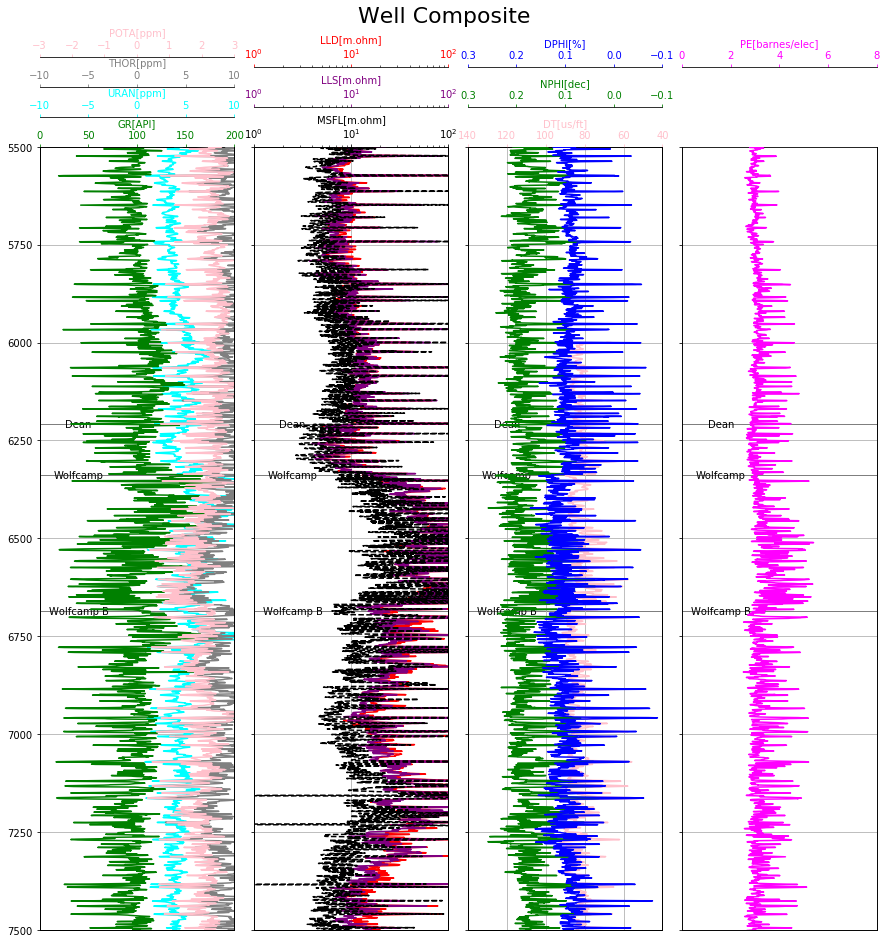

In [6]:
# Bulk of code format below barrowed from PetroGG, as shown here
# https://github.com/petroGG/Basic-Well-Log-Interpretation/blob/master/Basic%20well%20log%20interpretation.ipynb

def triple_combo_plot(top_depth,bottom_depth):
    
    logs=df_all[(df_all.DEPT >= top_depth) & (df_all.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15), sharey=True)
    fig.suptitle("Well Composite", fontsize=22)
    fig.subplots_adjust(top=0.85,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(tops_depths,tops):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.2, i ,j, horizontalalignment='center',verticalalignment='center')
    
        
#1st track: GR, and Spectral Curves
            
    ax01=ax[0].twiny()
    ax01.set_xlim(-10,10)
    ax01.plot(df_all.URAN, df_all.DEPT, label='URAN[ppm]', color='cyan') 
    ax01.spines['top'].set_position(('outward',30))
    ax01.set_xlabel('URAN[ppm]',color='cyan')    
    ax01.tick_params(axis='x', colors='cyan')
    
    ax02=ax[0].twiny()
    ax02.set_xlim(0,200)
    ax02.plot(df_all.GR, df_all.DEPT, label='GR[API]', color='green') 
    ax02.spines['top'].set_position(('outward',0))
    ax02.set_xlabel('GR[API]',color='green')    
    ax02.tick_params(axis='x', colors='green')
    
    ax03=ax[0].twiny()
    ax03.set_xlim(-10,10)
    ax03.plot(df_all.THOR, df_all.DEPT, label='THOR[ppm]', color='gray') 
    ax03.spines['top'].set_position(('outward',60))
    ax03.set_xlabel('THOR[ppm]',color='gray')    
    ax03.tick_params(axis='x', colors='gray')
    
    ax04=ax[0].twiny()
    ax04.set_xlim(-3,3)
    ax04.plot(df_all.POTA, df_all.DEPT, label='POTA[ppm]', color='pink') 
    ax04.spines['top'].set_position(('outward',90))
    ax04.set_xlabel('POTA[ppm]',color='pink')    
    ax04.tick_params(axis='x', colors='pink')
    
#2nd track: Resistivities

    ax11=ax[1].twiny()
    ax11.set_xlim(1,100)
    ax11.set_xscale('log')
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',80))
    ax11.set_xlabel('LLD[m.ohm]', color='red')
    ax11.plot(df_all.LLD, df_all.DEPT, label='LLD[m.ohm]', color='red')
    ax11.tick_params(axis='x', colors='red')    
    
    ax12=ax[1].twiny()
    ax12.set_xlim(1,100)
    ax12.set_xscale('log')
    ax12.plot(df_all.LLS, df_all.DEPT, label='ILS[m.ohm]', color='purple') 
    ax12.spines['top'].set_position(('outward',40))
    ax12.set_xlabel('LLS[m.ohm]', color='purple')    
    ax12.tick_params(axis='x', colors='purple')
    
    ax13=ax[1].twiny()
    ax13.set_xlim(1,100)
    ax13.set_xscale('log')
    ax13.plot(df_all.MSFL, df_all.DEPT, '--',label='MSFL[m.ohm]', color='black') 
    ax13.spines['top'].set_position(('outward',0))
    ax13.set_xlabel('MSFL[m.ohm]',color='black')
    ax13.tick_params(axis='x', colors='black')


#3rd track: DT, RHOB, NPHI track
    
    ax21=ax[2].twiny()
    ax21.grid(True)
    ax21.set_xlim(140,40)
    ax21.spines['top'].set_position(('outward',0))
    ax21.set_xlabel('DT[us/ft]')
    ax21.plot(df_all.DTC, df_all.DEPT, label='DT[us/ft]', color='pink')
    ax21.set_xlabel('DT[us/ft]', color='pink')    
    ax21.tick_params(axis='x', colors='pink')
    
    ax22=ax[2].twiny()
    ax22.set_xlim(-.1,.3)
    ax22.invert_xaxis()
    ax22.plot(df_all.NPHI, df_all.DEPT, label='NPHI[%]', color='green') 
    ax22.spines['top'].set_position(('outward',40))
    ax22.set_xlabel('NPHI[dec]', color='green')    
    ax22.tick_params(axis='x', colors='green')
    
    ax23=ax[2].twiny()
    ax23.set_xlim(0.3,-.1)
    ax23.plot(df_all.DPHI, df_all.DEPT ,label='DPHI[%]', color='blue') 
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('DPHI[%]',color='blue')
    ax23.tick_params(axis='x', colors='blue')
    
# 4th track PEF
    ax23=ax[3].twiny()
    ax23.set_xlim(0,8)
    ax23.plot(df_all.PE, df_all.DEPT ,label='PE[barnes/elec]', color='magenta') 
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('PE[barnes/elec]',color='magenta')
    ax23.tick_params(axis='x', colors='magenta')
    
    #plt.savefig ('triple_combo_plot.png', dpi=200, format='png')
top_depth = 5500
bottom_depth = 7500
print(triple_combo_plot(top_depth, bottom_depth))

None


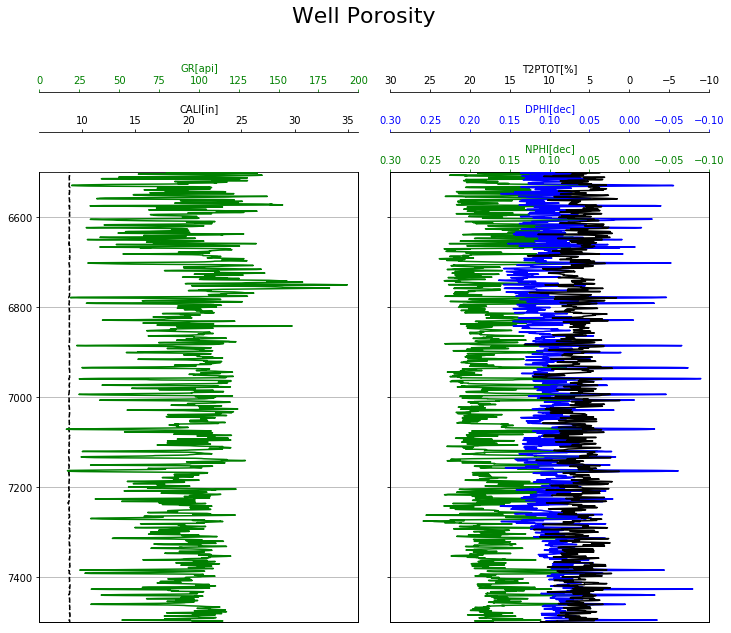

In [7]:
# Inital Porosity plot comparing delivered "Triple Combo Porosities" with NMR
# note poor overlap of T2PTOT 
def porosity_plot(top_depth,bottom_depth):
    
    logs=df_all[(df_all.DEPT >= top_depth) & (df_all.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10), sharey=True)
    fig.suptitle("Well Porosity", fontsize=22)
    fig.subplots_adjust(top=0.75,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
#         for (i,j) in zip(tops_depths,tops):
#             if ((i>=top_depth) and (i<=bottom_depth)):
#                 axes.axhline(y=i, linewidth=0.5, color='black')
#                 axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
    
        
# 1st track: GR, CALI, SP track
    
    ax01=ax[0].twiny()
    ax01.set_xlim(6,36)
    ax01.plot(df_all.CALI, df_all.DEPT, '--', label='CALN[in]', color='black') 
    ax01.spines['top'].set_position(('outward',40))
    ax01.set_xlabel('CALI[in]',color='black')    
    ax01.tick_params(axis='x', colors='black')
    
    ax02=ax[0].twiny()
    ax02.set_xlim(0,200)
    ax02.plot(df_all.GR, df_all.DEPT, label='GR[api]', color='green') 
    ax02.spines['top'].set_position(('outward',80))
    ax02.set_xlabel('GR[api]',color='green')    
    ax02.tick_params(axis='x', colors='green')


#2nd track: t2PTOT, DPHI, NPHI track
    
    ax10=ax[1].twiny()
    ax10.set_xlim(.3,-.1)
    ax10.plot(df_all.NPHI, df_all.DEPT, label='NPHI[dec]', color='green') 
    ax10.spines['top'].set_position(('outward',0))
    ax10.set_xlabel('NPHI[dec]', color='green')    
    ax10.tick_params(axis='x', colors='green')
    
    ax11=ax[1].twiny()
    ax11.set_xlim(.3,-.1)
    ax11.plot(df_all.DPHI, df_all.DEPT ,label='DPHI[dec]', color='blue') 
    ax11.spines['top'].set_position(('outward',40))
    ax11.set_xlabel('DPHI[dec]',color='blue')
    ax11.tick_params(axis='x', colors='blue')
    
        
    ax12=ax[1].twiny()
    ax12.set_xlim(30,-10)
    ax12.plot(df_all.T2PTOT, df_all.DEPT ,label='T2PTOT[%]', color='black') 
    ax12.spines['top'].set_position(('outward',80))
    ax12.set_xlabel('T2PTOT[%]',color='black')
    ax12.tick_params(axis='x', colors='black')
    
    #plt.savefig ('triple_combo_plot.png', dpi=200, format='png')
top_depth = 6500
bottom_depth = 7500
print(porosity_plot(top_depth, bottom_depth))

# 4a.  Creation of deterministic mineralogical model 
 Variables to be created:
     1.  Volume: quartz, carbonate, clay, TOC, PHIE
     2.  Facies (categorial): Sand, Carbonate, Organic Shale, Shale (non-organic)

In [8]:
# Combine montmorillonite and illite volume from GEM spectroscopy log to provide target modeling total vclay volume (suspiciously high values encountered from GEM stats)

df_all["vclay_gem"]= df_all.MONTMORILLONITEVOLUME + df_all.ILLITEVOLUME
df_all["vclay_gem"].describe()

count    6838.000000
mean        0.484521
std         0.186005
min         0.000000
25%         0.367100
50%         0.476100
75%         0.606900
max         0.978600
Name: vclay_gem, dtype: float64

In [9]:
# clay volume (NPHI,DPHI, Thorium)
c = .02
v = 0.0
def vclay(dphi, nphi,thor):
    vclay = ((c*(thor**2.40)*(nphi-dphi))+v)
    return vclay
df_all['VCLAY'] = vclay(df_all['DPHI'], df_all['NPHI'], df_all['THOR']).clip(0,1)


# TOC Weight Fraction (Passey)
# Mean values are reasonable. Unfortunately, dataset does not include pyrolysis data to calibrate further.  
sf = 1.1
LOM = 10
so = 0
resd_base = 3
rhob_base = 2.55

def WTOC(rhob, resd, resd_base, rhob_base):
    DlogR = np.log10(resd/resd_base) - 2.5* (rhob-rhob_base)
    WTOC = (sf*DlogR*10**(0.297-0.1688*LOM))+so
    return WTOC

df_all["TOCp"] = WTOC(df_all["RHOB"], df_all["LLD"], resd_base, rhob_base).clip(0,1)
  
    
print(df_all["VCLAY"].describe())
print(df_all["TOCp"].describe())

count    6837.000000
mean        0.489294
std         0.304638
min         0.000000
25%         0.237188
50%         0.446927
75%         0.731727
max         1.000000
Name: VCLAY, dtype: float64
count    6896.000000
mean        0.029994
std         0.018058
min         0.000000
25%         0.017216
50%         0.026166
75%         0.039813
max         0.123882
Name: TOCp, dtype: float64


In [10]:
# quartz model from PE (proven to work well in Wolfcamp in Delaware Basin)
def qtz(pe):
    qtz = (-28.65*pe**1.12 + 137.20)/100
    return qtz


df_all["QTZ"] = qtz(df_all.PE).clip(0,1)

(df_all["TOCp"].describe())

count    6896.000000
mean        0.029994
std         0.018058
min         0.000000
25%         0.017216
50%         0.026166
75%         0.039813
max         0.123882
Name: TOCp, dtype: float64

None


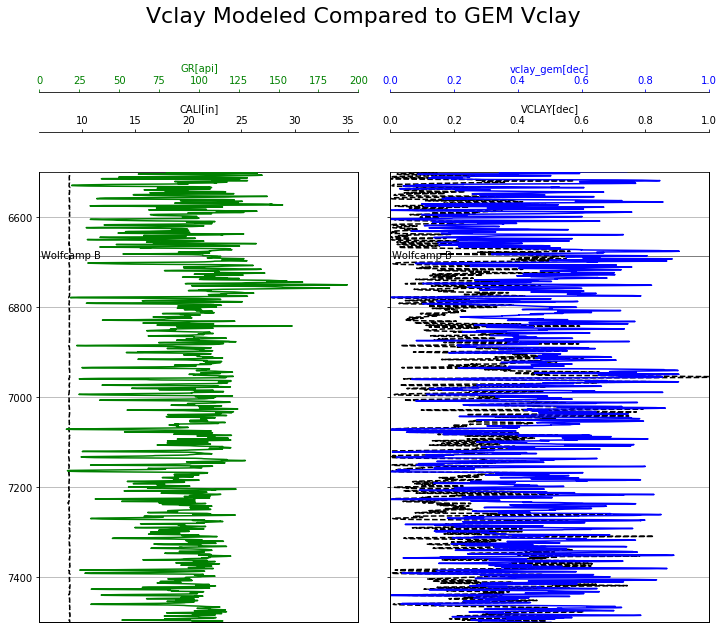

In [11]:
def qtz_plot(top_depth,bottom_depth):
    logs=df_all[(df_all.DEPT >= top_depth) & (df_all.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10), sharey=True)
    fig.suptitle("Vclay Modeled Compared to GEM Vclay", fontsize=22)
    fig.subplots_adjust(top=0.75,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(tops_depths,tops):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
    
        
# 1st track: GR, CALI, SP track
   
    
    ax01=ax[0].twiny()
    ax01.set_xlim(6,36)
    ax01.plot(df_all.CALI, df_all.DEPT, '--', label='CALN[in]', color='black') 
    ax01.spines['top'].set_position(('outward',40))
    ax01.set_xlabel('CALI[in]',color='black')    
    ax01.tick_params(axis='x', colors='black')
    
    ax02=ax[0].twiny()
    ax02.set_xlim(0,200)
    ax02.plot(df_all.GR, df_all.DEPT, label='GR[api]', color='green') 
    ax02.spines['top'].set_position(('outward',80))
    ax02.set_xlabel('GR[api]',color='green')    
    ax02.tick_params(axis='x', colors='green')
    
# 2nd track; vclay(modeled), vclay from GEM

    ax11=ax[1].twiny()
    ax11.set_xlim(0,1)
    ax11.plot(df_all.VCLAY, df_all.DEPT, '--', label='VCLAY[dec]', color='black') 
    ax11.spines['top'].set_position(('outward',40))
    ax11.set_xlabel('VCLAY[dec]',color='black')    
    ax11.tick_params(axis='x', colors='black')
    
    ax12=ax[1].twiny()
    ax12.set_xlim(0,1)
    ax12.plot(df_all.vclay_gem, df_all.DEPT, label='vclay_gem[dec]', color='blue') 
    ax12.spines['top'].set_position(('outward',80))
    ax12.set_xlabel('vclay_gem[dec]',color='blue')    
    ax12.tick_params(axis='x', colors='blue')
    

top_depth =6500
bottom_depth =7500
print(qtz_plot(top_depth, bottom_depth))

In [12]:
# Combine CALC and DOLOMITE curves from GEM to create total carbonate volume, which will targeted using triple combo curves

df_all["CARB"] = df_all.CALC + df_all.DOLOMITE
print(df_all["CARB"].describe())

# Create basic effective porosity curve for volume and mineraloty calcs below

df_all["PHIE"] = (df_all.DPHI * df_all.VCLAY).clip(0,1)
print(df_all["PHIE"].describe())

count    6838.000000
mean        0.105819
std         0.135233
min         0.000000
25%         0.025500
50%         0.048150
75%         0.126400
max         0.817800
Name: CARB, dtype: float64
count    6837.000000
mean        0.034685
std         0.020660
min         0.000000
25%         0.019403
50%         0.034891
75%         0.048459
max         0.150176
Name: PHIE, dtype: float64


In [13]:
# mineralogy model for quartz and carbonate
x = 1
def min1(pe, vsh, rhob, nphi):
    uma = pe*rhob/(1-nphi)
    min1 = (uma-13.79)/(4.79-13.79)*x
    return min1

def min2(pe, vsh, rhob, nphi):
    uma = pe*rhob/(1-nphi)
    min1 = (uma-13.79)/(4.79-13.79)*x
    min2 = 1.0 - min1
    return min2

def vmin1(pe, vsh, rhob, nphi,vclay, phie,toc):
    uma = 1.1*pe**.80*rhob/(1-nphi)
    min1 = (uma-13.79)/(4.79-13.79)*x
    min2 = 1.0 - min1
    vrock = 1-vclay-phie-toc
    vmin1 = min1*vrock
    return vmin1

def vmin2(pe, vsh, rhob, nphi,vclay, phie,toc):
    uma = .8*pe**.80*rhob/(1-nphi)
    min1 = (uma-13.79)/(4.79-13.79)*x
    min2 = 1.0 - min1
    vrock = 1- (vclay+phie+toc)
    vmin2 = min2*vrock
    return vmin2
        
df_all["qtz_m"]= min1(df_all["PE"], df_all["VCLAY"], df_all["RHOB"], df_all["NPHI"]).clip (0,1)
df_all["carb_m"]= min2(df_all["PE"], df_all["VCLAY"], df_all["RHOB"], df_all["NPHI"]).clip(0,1)

df_all["qtz_v"]= vmin1(df_all["PE"], df_all["VCLAY"], df_all["RHOB"], df_all["NPHI"],df_all["VCLAY"], df_all["PHIE"],df_all["TOCp"]).clip(0,1)
df_all["carb_v"]= vmin2(df_all["PE"], df_all["VCLAY"], df_all["RHOB"], df_all["NPHI"],df_all["VCLAY"], df_all["PHIE"],df_all["TOCp"]).clip(0,1)


# Review Mean and Median Values

print("Modeled Quartz Median:", df_all["qtz_v"].median())
print("GEM Quartz Median:",df_all.QRTZ.median())

print("Modeled Carbonate Median:",df_all["carb_v"].mean())
print("GEM Carbonate Median:",df_all.CARB.mean())


Modeled Quartz Median: 0.2653363770140338
GEM Quartz Median: 0.27895000000000003
Modeled Carbonate Median: 0.08359707281605258
GEM Carbonate Median: 0.1058194647557763


In [14]:
pd.set_option('display.max_columns',50)
df_all[["TOCp", "VCLAY", "qtz_v", "carb_v"]]

TOCp     VCLAY     qtz_v    carb_v
DEPT                                          
5490.0  0.013747  0.146372  0.460720  0.150563
5490.5  0.019927  0.209803  0.440767  0.118185
5491.0  0.024717  0.170926  0.503896  0.092370
5491.5  0.025545  0.128329  0.578721  0.065317
5492.0  0.027762  0.125205  0.603009  0.049094
5492.5  0.032030  0.120711  0.593713  0.055099
5493.0  0.038161  0.161799  0.520500  0.076051
5493.5  0.041301  0.214824  0.452134  0.089207
5494.0  0.034730  0.263140  0.394949  0.109112
5494.5  0.024667  0.277364  0.359686  0.138771
5495.0  0.022773  0.245929  0.380369  0.143260
5495.5  0.025896  0.223496  0.426056  0.116990
5496.0  0.026613  0.282168  0.400611  0.094841
5496.5  0.026677  0.282507  0.395909  0.097710
5497.0  0.028903  0.303113  0.362849  0.108301
5497.5  0.026989  0.253811  0.421298  0.099734
5498.0  0.027240  0.233367  0.486378  0.066349
5498.5  0.028960  0.243463  0.507110  0.044342
5499.0  0.031384  0.368619  0.376892  0.056071
5499.5  0.037379  0.545906  0.203436  0.057508
5500.0  0.041011  0.478776  0.237303  0.071925
5500.5  0.034691  0.327111  0.380390  0.074982
5501.0  0.025265  0.237841  0.504076  0.051147
5501.5  0.021558  0.230799  0.513833  0.050949
5502.0  0.018146  0.355211  0.383045  0.068276
5502.5  0.016741  0.493490  0.265823  0.066327
5503.0  0.014752  0.518623  0.236605  0.073442
5503.5  0.014254  0.520986  0.216901  0.086810
5504.0  0.017060  0.481034  0.248842  0.087449
5504.5  0.020234  0.370353  0.356309  0.079384
5505.0  0.014524  0.309959  0.405691  0.090931
5505.5  0.009784  0.265044  0.417550  0.117370
5506.0  0.011046  0.249486  0.425150  0.118080
5506.5  0.014918  0.294594  0.395650  0.104187
5507.0  0.020178  0.356221  0.346117  0.094245
5507.5  0.024175  0.352981  0.343205  0.092995
5508.0  0.025492  0.390093  0.316744  0.086497
5508.5  0.022006  0.427472  0.301131  0.076408
5509.0  0.021898  0.517548  0.241103  0.062351
5509.5  0.024533  0.544447  0.224735  0.052789
5510.0  0.027307  0.483336  0.274573  0.051750
5510.5  0.029065  0.425953  0.325351  0.052384
5511.0  0.029565  0.318730  0.414238  0.058365
5511.5  0.031755  0.254182  0.450147  0.071261
5512.0  0.035435  0.238316  0.443928  0.082193
5512.5  0.038147  0.277686  0.406425  0.081381
5513.0  0.039015  0.308194  0.383340  0.076902
5513.5  0.036186  0.315756  0.375200  0.079745
5514.0  0.030469  0.272143  0.417886  0.083005
5514.5  0.023810  0.257187  0.443672  0.080366
5515.0  0.020391  0.187495  0.516782  0.075322
5515.5  0.018445  0.198871  0.497681  0.083677
5516.0  0.019443  0.223289  0.473087  0.085528
5516.5  0.022105  0.298818  0.410432  0.081797
5517.0  0.024404  0.393968  0.321865  0.083303
5517.5  0.027661  0.384848  0.321120  0.084456
5518.0  0.027333  0.372153  0.335597  0.080523
5518.5  0.025295  0.423225  0.302438  0.073259
5519.0  0.023279  0.486036  0.261768  0.063262
5519.5  0.022589  0.478664  0.277603  0.057676
5520.0  0.022979  0.531656  0.241201  0.052827
5520.5  0.024661  0.593846  0.191222  0.048712
5521.0  0.030219  0.534325  0.224366  0.055881
5521.5  0.036904  0.396094  0.316414  0.071422
5522.0  0.045290  0.315479  0.365092  0.083485
5522.5  0.047112  0.257697  0.384641  0.112045
5523.0  0.045823  0.183476  0.386923  0.165897
5523.5  0.033212  0.113453  0.390377  0.212834
5524.0  0.024323  0.128524  0.348298  0.239838
5524.5  0.022884  0.218597  0.315487  0.210464
5525.0  0.028748  0.298676  0.331167  0.137423
5525.5  0.031430  0.331058  0.356077  0.091331
5526.0  0.028739  0.320642  0.383677  0.079879
5526.5  0.024474  0.296340  0.416321  0.076443
5527.0  0.021975  0.330877  0.392868  0.074144
5527.5  0.022688  0.367540  0.360638  0.073231
5528.0  0.024897  0.416436  0.314265  0.073795
5528.5  0.026448  0.480454  0.252609  0.076478
5529.0  0.028508  0.513530  0.220341  0.074894
5529.5  0.027178  0.469341  0.252032  0.079546
5530.0  0.022166  0.418938  0.303614  0.080221
5530.5  0.016352  0.329769  0.396612  0.074492
5531.0  0.014642  0.299307  0.434118  0.067335
5531.5  0.012487 

In [15]:
# Normalize deterministic volumes to 100%

df_all["min_v"] = df_all.VCLAY + df_all.PHIE + df_all.TOCp + df_all.qtz_v + df_all.carb_v
df_all.VCLAY = df_all.VCLAY/ df_all.min_v
df_all.PHIE = df_all.PHIE / df_all.min_v
df_all.TOCp = df_all.TOCp / df_all.min_v
df_all.qtz_v = df_all.qtz_v / df_all.min_v
df_all.carb_v = df_all.carb_v / df_all.min_v



None


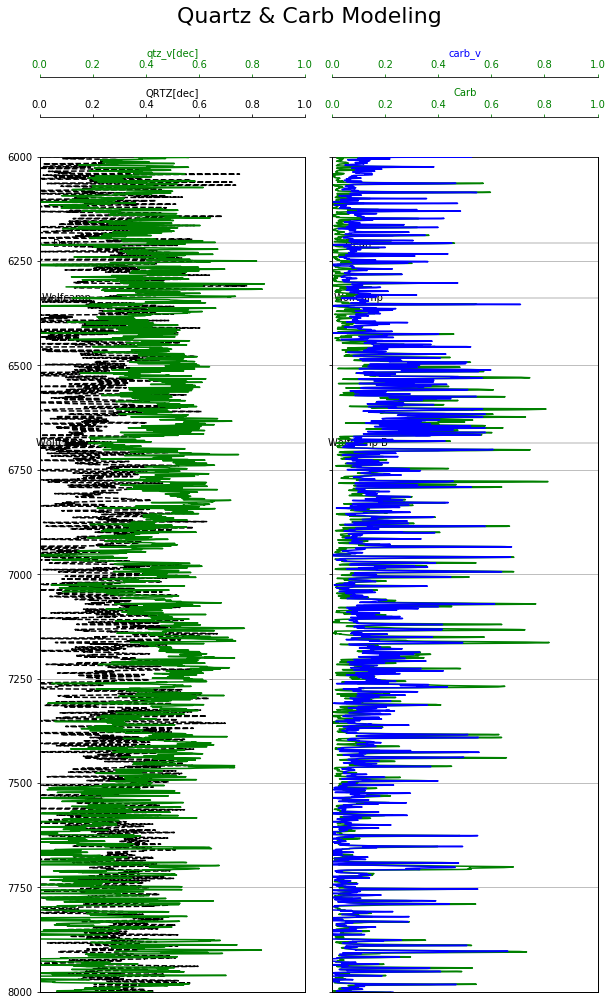

In [16]:
# Create Quartz and Carbonate Model/GEM Comparison Chart

def qtz_plot(top_depth,bottom_depth):
    
    logs=df_all[(df_all.DEPT >= top_depth) & (df_all.DEPT <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,16), sharey=True)
    fig.suptitle("Quartz & Carb Modeling", fontsize=22)
    fig.subplots_adjust(top=0.85,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(tops_depths,tops):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.3, color='black')
                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
    
        
# 1st track: Modeled Quartz and GEM Quartz
    
    ax01=ax[0].twiny()
    ax01.set_xlim(0,1)
    ax01.plot(df_all.QRTZ, df_all.DEPT, '--', label='QRTZ[dec]', color='black') 
    ax01.spines['top'].set_position(('outward',40))
    ax01.set_xlabel('QRTZ[dec]',color='black')    
    ax01.tick_params(axis='x', colors='black')
    
    ax02=ax[0].twiny()
    ax02.set_xlim(0,1)
    ax02.plot(df_all.qtz_v, df_all.DEPT, label='qtz_v[dec]', color='green') 
    ax02.spines['top'].set_position(('outward',80))
    ax02.set_xlabel('qtz_v[dec]',color='green')    
    ax02.tick_params(axis='x', colors='green')
    

# 2nd Track: Modeled Carbonate and GEM Carbonate

    
    ax05=ax[1].twiny()
    ax05.set_xlim(0,1)
    ax05.plot(df_all.CARB, df_all.DEPT, label='Carb[dec]', color='green') 
    ax05.spines['top'].set_position(('outward',40))
    ax05.set_xlabel('Carb',color='green')    
    ax05.tick_params(axis='x', colors='green')
    
    ax06=ax[1].twiny()
    ax06.set_xlim(0,1)
    ax06.plot(df_all.carb_v, df_all.DEPT, label='carb_v', color='blue') 
    ax06.spines['top'].set_position(('outward',80))
    ax06.set_xlabel('carb_v',color='blue')    
    ax06.tick_params(axis='x', colors='green')

top_depth =6000
bottom_depth =8000
print(qtz_plot(top_depth, bottom_depth))


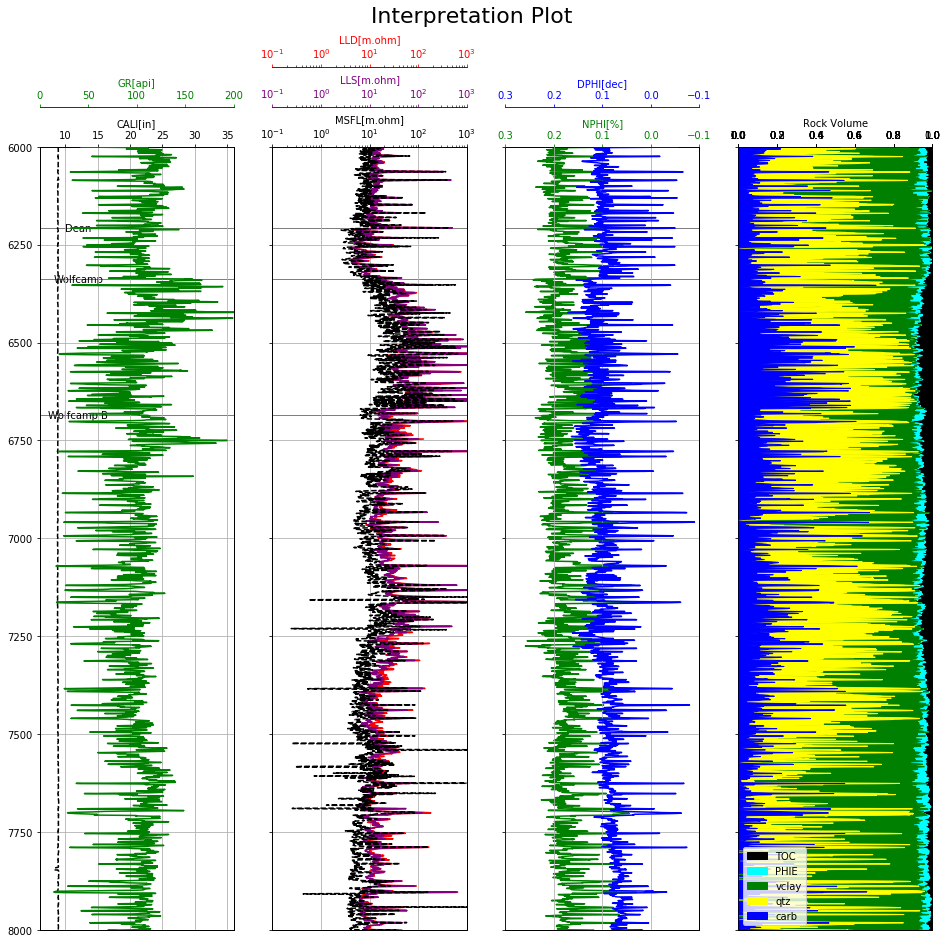

In [17]:

# Create the figure and subplots

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,15), sharey=True)
fig.suptitle("Interpretation Plot", fontsize=22)
fig.subplots_adjust(top=0.85,wspace=0.2)

#General setting for all axis
for axes in ax:
    axes.set_ylim (top_depth,bottom_depth)
    axes.invert_yaxis()
    axes.yaxis.grid(True)
    axes.get_xaxis().set_visible(False)
    for i in tops_depths:
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
for (i,j) in zip(tops_depths,tops):
    if ((i>=top_depth) and (i<=bottom_depth)):
        ax[0].text(0.2, i ,j, horizontalalignment='center',verticalalignment='center')  
        
#1st track: GR, CALI track
    
ax01=ax[0].twiny()
ax01.set_xlim(6,36)
ax01.grid(True)
ax01.plot(df_all.CALI, df_all.DEPT, '--', label='CALI[in]', color='black') 
ax01.spines['top'].set_position(('outward',0))
ax01.set_xlabel('CALI[in]',color='black')    
ax01.tick_params(axis='x', colors='black')
    
ax02=ax[0].twiny()
ax02.set_xlim(0,200)
ax02.plot(df_all.GR, df_all.DEPT, label='GR[api]', color='green') 
ax02.spines['top'].set_position(('outward',40))
ax02.set_xlabel('GR[api]',color='green')    
ax02.tick_params(axis='x', colors='green')

#2nd track: Resistivities

ax11=ax[1].twiny()
ax11.set_xlim(0.1,1000)
ax11.set_xscale('log')
ax11.grid(True)
ax11.spines['top'].set_position(('outward',80))
ax11.set_xlabel('LLD[m.ohm]', color='red')
ax11.plot(df_all.LLD, df_all.DEPT, label='LLD[m.ohm]', color='red')
ax11.tick_params(axis='x', colors='red')    

ax12=ax[1].twiny()
ax12.set_xlim(0.1,1000)
ax12.set_xscale('log')
ax12.plot(df_all.LLS, df_all.DEPT, label='LLS[m.ohm]', color='purple') 
ax12.spines['top'].set_position(('outward',40))
ax12.set_xlabel('LLS[m.ohm]', color='purple')    
ax12.tick_params(axis='x', colors='purple')
    
ax13=ax[1].twiny()
ax13.set_xlim(0.1,1000)
ax13.set_xscale('log')
ax13.plot(df_all.MSFL, df_all.DEPT, '--',label='MSFL[m.ohm]', color='black') 
ax13.spines['top'].set_position(('outward',0))
ax13.set_xlabel('MSFL[m.ohm]',color='black')
ax13.tick_params(axis='x', colors='black')

#3rd track: DPHI,NPHI track
    
ax22=ax[2].twiny()
ax22.set_xlim(-.1,.3)
ax22.invert_xaxis()
ax22.plot(df_all.NPHI, df_all.DEPT, label='NPHI[dec]', color='green') 
ax22.spines['top'].set_position(('outward',0))
ax22.set_xlabel('NPHI[%]', color='green')    
ax22.tick_params(axis='x', colors='green')
    
ax24=ax[2].twiny()
ax24.grid(True)
ax24.set_xlim(.3,-.1)
ax24.spines['top'].set_position(('outward',40))
ax24.set_xlabel('DPHI[dec]')
ax24.plot(df_all.DPHI, df_all.DEPT, label='DPHI[dec]', color='blue')
ax24.set_xlabel('DPHI[dec]', color='blue')    
ax24.tick_params(axis='x', colors='blue')


#6th track: PHIE, MATRIX, VCL

ax50=ax[3].twiny()
ax50.set_xlim(0,1)
# ax50.spines['top'].set_position(('outward',0))
ax50.plot(df_all.PHIE, df_all.DEPT, label='PHIE', color='black',linewidth=0.5)
ax50.set_xlabel('Rock Volume', color='black')    
ax50.tick_params(axis='x', colors='black')

ax51=ax[3].twiny()
ax51.set_xlim(0,1)
# ax51.spines['top'].set_position(('outward',40))
ax51.plot(df_all.TOCp, df_all.DEPT, color='black',linewidth=0.5)
# ax51.set_xlabel('TOC', color='black')    
# ax51.tick_params(axis='x', colors='black')

ax52=ax[3].twiny()
ax52.set_xlim(0,1)
# ax52.spines['top'].set_position(('outward',80))
ax52.plot(df_all.VCLAY, df_all.DEPT, label='VCL', color='green',linewidth=0.5)
# ax52.set_xlabel('VCL', color='green')    
# ax52.tick_params(axis='x', colors='green')

ax53=ax[3].twiny()
ax53.set_xlim(0,1)
# ax53.spines['top'].set_position(('outward',80))
ax53.plot(df_all.qtz_v, df_all.DEPT, label='qtz_v', color='green',linewidth=0.5)
# ax53.set_xlabel('qtz_v', color='green')    
# ax53.tick_params(axis='x', colors='green')

ax53=ax[3].twiny()
ax53.set_xlim(0,1)
# ax53.spines['top'].set_position(('outward',80))
ax53.plot(df_all.carb_v, df_all.DEPT, label='carb_v', color='red',linewidth=0.5)
# ax53.set_xlabel('qtz_v', color='blue')    
# ax53.tick_params(axis='x', colors='blue')

df_all["disp_phie"] = df_all["TOCp"] + df_all["PHIE"]
df_all["disp_vcl"] = df_all["TOCp"] + df_all["PHIE"] + df_all["VCLAY"]
df_all["disp_qtz"]= df_all["TOCp"] + df_all["PHIE"] + df_all["VCLAY"] + df_all["qtz_v"]
                                                                                               
ax52=ax[3].twiny()
ax52.set_xlim(1,0)
# ax52.spines['top'].set_position(('outward',0))
ax52.fill_betweenx(df_all.DEPT,0,df_all.TOCp,color='black',label='TOC')
ax52.fill_betweenx(df_all.DEPT,df_all.TOCp,df_all.disp_phie, color='cyan',label='PHIE')
ax52.fill_betweenx(df_all.DEPT,df_all.disp_phie,df_all.disp_vcl,color='green',label='vclay')
ax52.fill_betweenx(df_all.DEPT,df_all.disp_vcl,df_all.disp_qtz,color='yellow',label='qtz')                                    
ax52.fill_betweenx(df_all.DEPT,df_all.disp_qtz,1,color='blue',label='carb') 
ax52.legend(loc='lower left')




# 4b.  Creation of basic facies model (categorial variables)

Feet of Lithofacies Organic Shale:  1934.0
Feet of Lithofacies Non-Organic Shale:  962.0
Feet of Lithofacies Sand:  211.5
Feet of Lithofacies Carbonate:  311.0


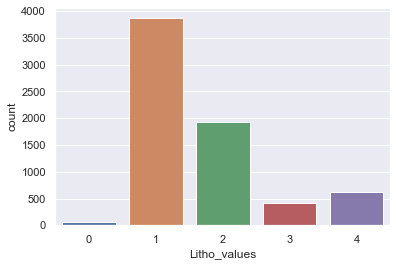

In [18]:
# create a list of our conditions (facies mineralogic volume cutoffs)
conditions = [
    (df_all['TOCp'] >= 0.02) & (df_all["VCLAY"] >= 0.20),
    (df_all['TOCp'] <= 0.02) & (df_all["VCLAY"] >= 0.20),
    (df_all["VCLAY"] < 0.20) & (df_all["carb_v"] < .22),
    (df_all["VCLAY"] < 0.20) & (df_all["carb_v"] > .22)]

# create a list of the values we want to assign for each condition

litho = ['OrgShale', 'Shale', 'Sand', 'Carb']
litho_values = [1,2,3,4]

# create a new column and use np.select to assign values to it using our lists as arguments

df_all['Litho'] = np.select(conditions, litho)
df_all['Litho_values'] = np.select(conditions, litho_values)

# display updated DataFrame
     
print("Feet of Lithofacies Organic Shale: ",0.5*df_all[df_all.Litho_values == 1].shape[0])
print("Feet of Lithofacies Non-Organic Shale: ",0.5*df_all[df_all.Litho_values == 2].shape[0])    
print("Feet of Lithofacies Sand: ",0.5*df_all[df_all.Litho_values == 3].shape[0])
print("Feet of Lithofacies Carbonate: ",0.5*df_all[df_all.Litho_values == 4].shape[0])

# title = "Count of Facies (ft)"

import seaborn as sns
sns.set(style="darkgrid")
# data = sns.load_dataset("df_all")
ax = sns.countplot(x="Litho_values", data=df_all).set_title('')


In [19]:
pd.set_option('display.max_columns',50)
df_all[["TOCp", "VCLAY", "qtz_v", "carb_v", "min_v", "Litho"]]

TOCp     VCLAY     qtz_v    carb_v     min_v     Litho
DEPT                                                              
5490.0  0.017692  0.188372  0.592918  0.193765  0.777037      Sand
5490.5  0.024746  0.260542  0.547362  0.146767  0.805255  OrgShale
5491.0  0.030589  0.211531  0.623598  0.114313  0.808045  OrgShale
5491.5  0.031584  0.158664  0.715524  0.080757  0.808808      Sand
5492.0  0.034089  0.153740  0.740435  0.060283  0.814398      Sand
5492.5  0.039426  0.148585  0.730809  0.067821  0.812405      Sand
5493.0  0.046788  0.198376  0.638164  0.093243  0.815620      Sand
5493.5  0.050170  0.260954  0.549225  0.108363  0.823223  OrgShale
5494.0  0.042189  0.319658  0.479777  0.132547  0.823193  OrgShale
5494.5  0.030428  0.342131  0.443676  0.171175  0.810695  OrgShale
5495.0  0.028384  0.306524  0.474089  0.178559  0.802315  OrgShale
5495.5  0.031979  0.275995  0.526138  0.144471  0.809781  OrgShale
5496.0  0.031986  0.339133  0.481489  0.113987  0.832026  OrgShale
5496.5  0.032097  0.339904  0.476345  0.117562  0.831139  OrgShale
5497.0  0.034748  0.364416  0.436232  0.130203  0.831780  OrgShale
5497.5  0.032779  0.308264  0.511684  0.121131  0.823355  OrgShale
5498.0  0.032776  0.280796  0.585226  0.079833  0.831093  OrgShale
5498.5  0.034406  0.289244  0.602468  0.052680  0.841721  OrgShale
5499.0  0.036250  0.425769  0.435325  0.064764  0.865772  OrgShale
5499.5  0.041167  0.601224  0.224051  0.063335  0.907991  OrgShale
5500.0  0.046121  0.538437  0.266873  0.080887  0.889197  OrgShale
5500.5  0.040749  0.384238  0.446822  0.088077  0.851324  OrgShale
5501.0  0.030164  0.283957  0.601815  0.061064  0.837593  OrgShale
5501.5  0.025809  0.276305  0.615146  0.060994  0.835302  OrgShale
5502.0  0.021212  0.415220  0.447757  0.079811  0.855475  OrgShale
5502.5  0.018892  0.556921  0.299991  0.074852  0.886104     Shale
5503.0  0.016607  0.583849  0.266363  0.082678  0.888282     Shale
5503.5  0.016131  0.589618  0.245475  0.098246  0.883599     Shale
5504.0  0.019493  0.549643  0.284333  0.099921  0.875176     Shale
5504.5  0.023689  0.433584  0.417142  0.092937  0.854169  OrgShale
5505.0  0.017424  0.371847  0.486693  0.109087  0.833566     Shale
5505.5  0.012055  0.326558  0.514458  0.144610  0.811630     Shale
5506.0  0.013650  0.308302  0.525379  0.145917  0.809225     Shale
5506.5  0.018049  0.356413  0.478674  0.126050  0.826554     Shale
5507.0  0.023850  0.421044  0.409101  0.111395  0.846042  OrgShale
5507.5  0.028519  0.416415  0.404883  0.109707  0.847665  OrgShale
5508.0  0.029679  0.454163  0.368767  0.100704  0.858928  OrgShale
5508.5  0.025292  0.491312  0.346102  0.087819  0.870063  OrgShale
5509.0  0.024464  0.578187  0.269353  0.069657  0.895122  OrgShale
5509.5  0.027076  0.600891  0.248034  0.058262  0.906067  OrgShale
5510.0  0.030532  0.540411  0.306996  0.057860  0.894387  OrgShale
5510.5  0.032981  0.483341  0.369184  0.059442  0.881270  OrgShale
5511.0  0.034586  0.372866  0.484596  0.068279  0.854812  OrgShale
5511.5  0.037958  0.303826  0.538067  0.085179  0.836601  OrgShale
5512.0  0.042677  0.287022  0.534657  0.098991  0.830304  OrgShale
5512.5  0.045401  0.330485  0.483702  0.096855  0.840239  OrgShale
5513.0  0.045943  0.362918  0.451408  0.090557  0.849210  OrgShale
5513.5  0.042612  0.371828  0.441829  0.093906  0.849199  OrgShale
5514.0  0.036436  0.325447  0.499735  0.099263  0.836215  OrgShale
5514.5  0.028628  0.309238  0.533465  0.096631  0.831679  OrgShale
5515.0  0.024956  0.229472  0.632482  0.092185  0.817071  OrgShale
5515.5  0.022609  0.243763  0.610025  0.102565  0.815836  OrgShale
5516.0  0.023692  0.272091  0.576486  0.104222  0.820639  OrgShale
5516.5  0.026349  0.356185  0.489226  0.097501  0.838940  OrgShale
5517.0  0.028379  0.458133  0.374287  0.096870  0.859944  OrgShale
5517.5  0.032190  0.447861  0.373699  0.098284  0.859302  OrgShale
5518.0  0.031838  0.433485  0.390903  0.093793  0.858515  OrgShale
5518.5  0.029008  0.485350  0.346833  0.084012  0.871998  O

In [20]:
# Create Facies Color map for display

facies_colors = ['gray', 'green','yellow','blue']
facies_labels = ['OrgShale','Shale', 'Sand', 'Carb']

#facies_color_map is a dictionary that maps facies labels to their respective colors

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Litho_values'] ]
    
logs = df_all.copy()
print(logs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



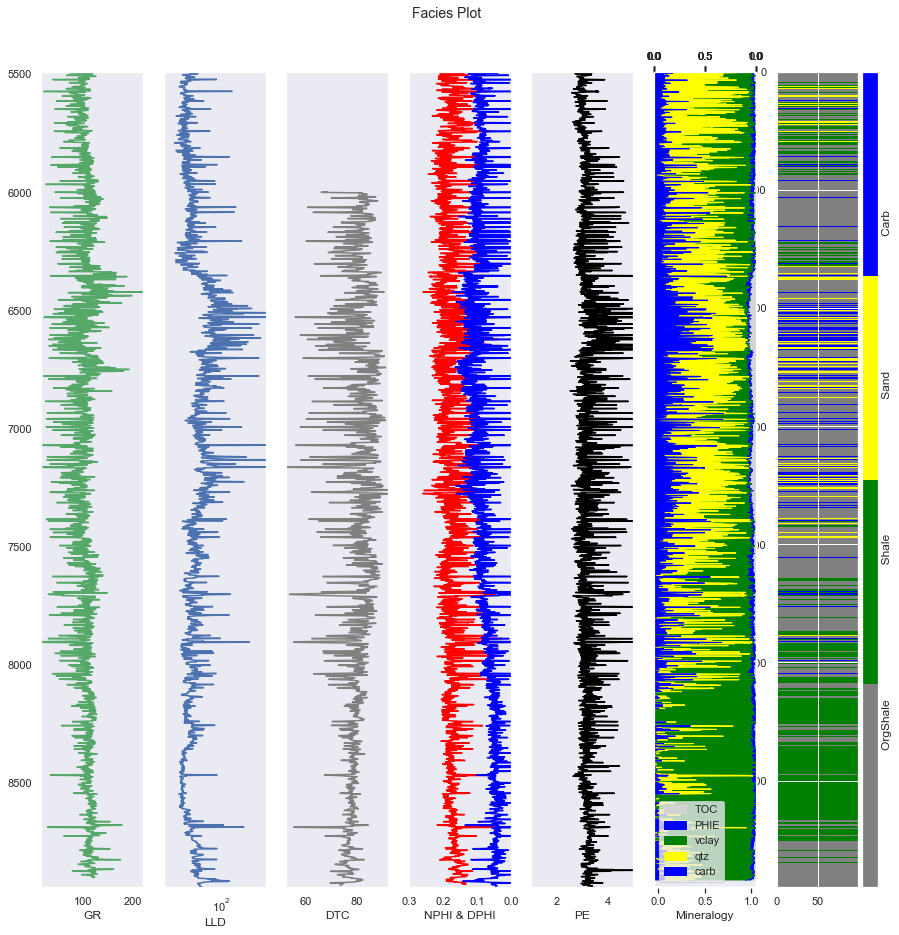

In [21]:

def make_facies_log_plot(df_all, facies_colors):
    #make sure logs are sorted by depth
#     logs = df_all.sort_values(by='DEPT')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPT.min(); zbot=logs.DEPT.max()
    
    cluster=np.repeat(np.expand_dims(df_all['Litho_values'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(15,15))
    ax[0].plot(df_all.GR, df_all.DEPT, '-g')
    ax[1].plot(df_all.LLD, df_all.DEPT, '-')
    ax[2].plot(df_all.DTC, df_all.DEPT, '-', color='0.5')
    ax[3].plot(df_all.NPHI, df_all.DEPT, '-', color='red')
    ax[3].plot(df_all.DPHI, df_all.DEPT, '-', color='blue')
    ax[4].plot(df_all.PE, df_all.DEPT, '-', color='black')
    im=ax[6].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=5)
    
    
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((40*' ').join(['OrgShale', 'Shale', 'Sand', 'Carb']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(df_all.GR.min(),df_all.GR.max())
    ax[1].set_xlabel("LLD")
    ax[1].set_xscale('log')
    ax[1].set_xlim(2,2000)
    ax[2].set_xlabel("DTC")
    ax[2].set_xlim(df_all.DTC.min(),df_all.DTC.max())
    ax[3].set_xlabel("NPHI & DPHI")
    ax[3].set_xlim(0.3, 0)
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(1,5)
    ax[5].set_xlabel('Mineralogy')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
#     ax[5].set_xticklabels([]);ax[6].set_xticklabels([])
    f.suptitle('Facies Plot', fontsize=14,y=0.94)
    
#Mineralogy plot

    ax50=ax[5].twiny()
    ax50.set_xlim(1,0)
#     ax50.spines['top'].set_position(('outward',0))
    ax50.plot(df_all.PHIE, df_all.DEPT, label='Volume 0-100', color='black',linewidth=0.5)
#     ax50.set_xlabel('PHIE]', color='blue')    
#     ax50.tick_params(axis='x', colors='blue')

    ax51=ax[5].twiny()
    ax51.set_xlim(0,1)
#     ax51.spines['top'].set_position(('outward',40))
    ax51.plot(df_all.TOCp, df_all.DEPT, label='TOC', color='black',linewidth=0.5)
#     ax51.set_xlabel('TOC', color='black')    
#     ax51.tick_params(axis='x', colors='black')

    ax52=ax[5].twiny()
    ax52.set_xlim(0,1)
#     ax52.spines['top'].set_position(('outward',80))
    ax52.plot(df_all.VCLAY, df_all.DEPT, label='VCL', color='green',linewidth=0.5)
#     ax52.set_xlabel('VCL', color='green')    
#     ax52.tick_params(axis='x', colors='green')

    ax53=ax[5].twiny()
    ax53.set_xlim(0,1)
#     ax53.spines['top'].set_position(('outward',80))
    ax53.plot(df_all.qtz_v, df_all.DEPT, label='qtz_v', color='green',linewidth=0.5)
#     ax53.set_xlabel('qtz_v', color='green')    
#     ax53.tick_params(axis='x', colors='green')

    ax53=ax[5].twiny()
    ax53.set_xlim(0,1)
#     ax53.spines['top'].set_position(('outward',80))
    ax53.plot(df_all.carb_v, df_all.DEPT, label='carb_v', color='blue',linewidth=0.5)
#     ax53.set_xlabel('qtz_v', color='blue')    
#     ax53.tick_params(axis='x', colors='blue')

    df_all["disp_phie"] = df_all["TOCp"] + df_all["PHIE"]
    df_all["disp_vcl"] = df_all["TOCp"] + df_all["PHIE"] + df_all["VCLAY"]
    df_all["disp_qtz"]= df_all["TOCp"] + df_all["PHIE"] + df_all["VCLAY"] + df_all["qtz_v"]

    ax52=ax[5].twiny()
    ax52.set_xlim(1,0)
#     ax52.spines['top'].set_position(('outward',0))
    ax52.fill_betweenx(df_all.DEPT,0,df_all.TOCp,color='lightgray',label='TOC')
    ax52.fill_betweenx(df_all.DEPT,df_all.TOCp,df_all.disp_phie, color='blue',label='PHIE')
    ax52.fill_betweenx(df_all.DEPT,df_all.disp_phie,df_all.disp_vcl,color='green',label='vclay')
    ax52.fill_betweenx(df_all.DEPT,df_all.disp_vcl,df_all.disp_qtz,color='yellow',label='qtz')                                    
    ax52.fill_betweenx(df_all.DEPT,df_all.disp_qtz,1,color='blue',label='carb') 
    ax52.legend(loc='lower left')


make_facies_log_plot(logs,facies_colors)

# 5.  Machine Learning Input Data exploration and visualization

In [22]:
# create dataframe of target variable (T2PTOT) and feature variables

df_var =pd.DataFrame(df_all, columns =["GR", "LLD", "LLS", "DTC", "NPHI", "DPHI", "PE", "VCLAY", "TOCp", "PHIE", "qtz_v", "carb_v", "URAN", "POTA", "THOR", "T2PTOT", "Litho"])

In [23]:
# Drop null values

print(df_var.info())

df_var = df_var.dropna()

df_var.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 6901 entries, 5490.0 to 8940.0
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GR      6821 non-null   float64
 1   LLD     6901 non-null   float64
 2   LLS     6901 non-null   float64
 3   DTC     5869 non-null   float64
 4   NPHI    6877 non-null   float64
 5   DPHI    6896 non-null   float64
 6   PE      6896 non-null   float64
 7   VCLAY   6837 non-null   float64
 8   TOCp    6837 non-null   float64
 9   PHIE    6837 non-null   float64
 10  qtz_v   6837 non-null   float64
 11  carb_v  6837 non-null   float64
 12  URAN    6837 non-null   float64
 13  POTA    6837 non-null   float64
 14  THOR    6837 non-null   float64
 15  T2PTOT  6901 non-null   float64
 16  Litho   6901 non-null   object 
dtypes: float64(16), object(1)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Float64Index: 5802 entries, 5999.5 to 8900.0
Data columns (total 17 columns):
 #   Co

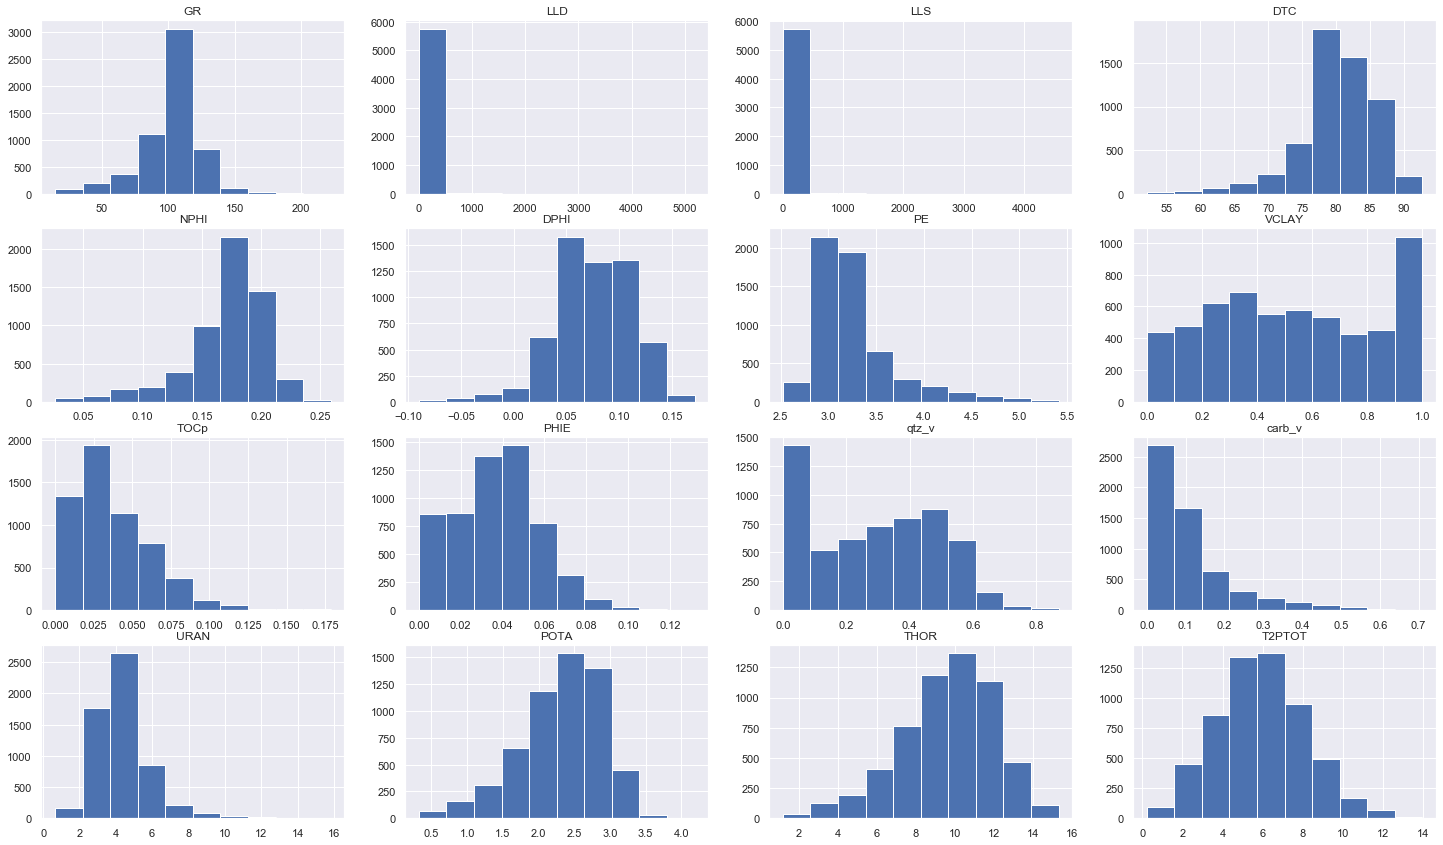

In [24]:
# Create Histogram Plots of new dataframe columns

dict = {'GR':1,'LLD':2, 'LLS':3, 'DTC':4, 'NPHI':5,
        'DPHI':6, 'PE':7, 'VCLAY':8,'TOCp':9,'PHIE':10,
       'qtz_v':11, 'carb_v':12,'URAN':13,'POTA':14,
       'THOR':15,'T2PTOT':16}

import matplotlib.pyplot as plt
plt.figure(figsize=(25,30))
for variable,i in dict.items():
                     plt.subplot(8,4,i)
                     plt.hist(df_var[variable])
                     plt.title(variable)

plt.show()



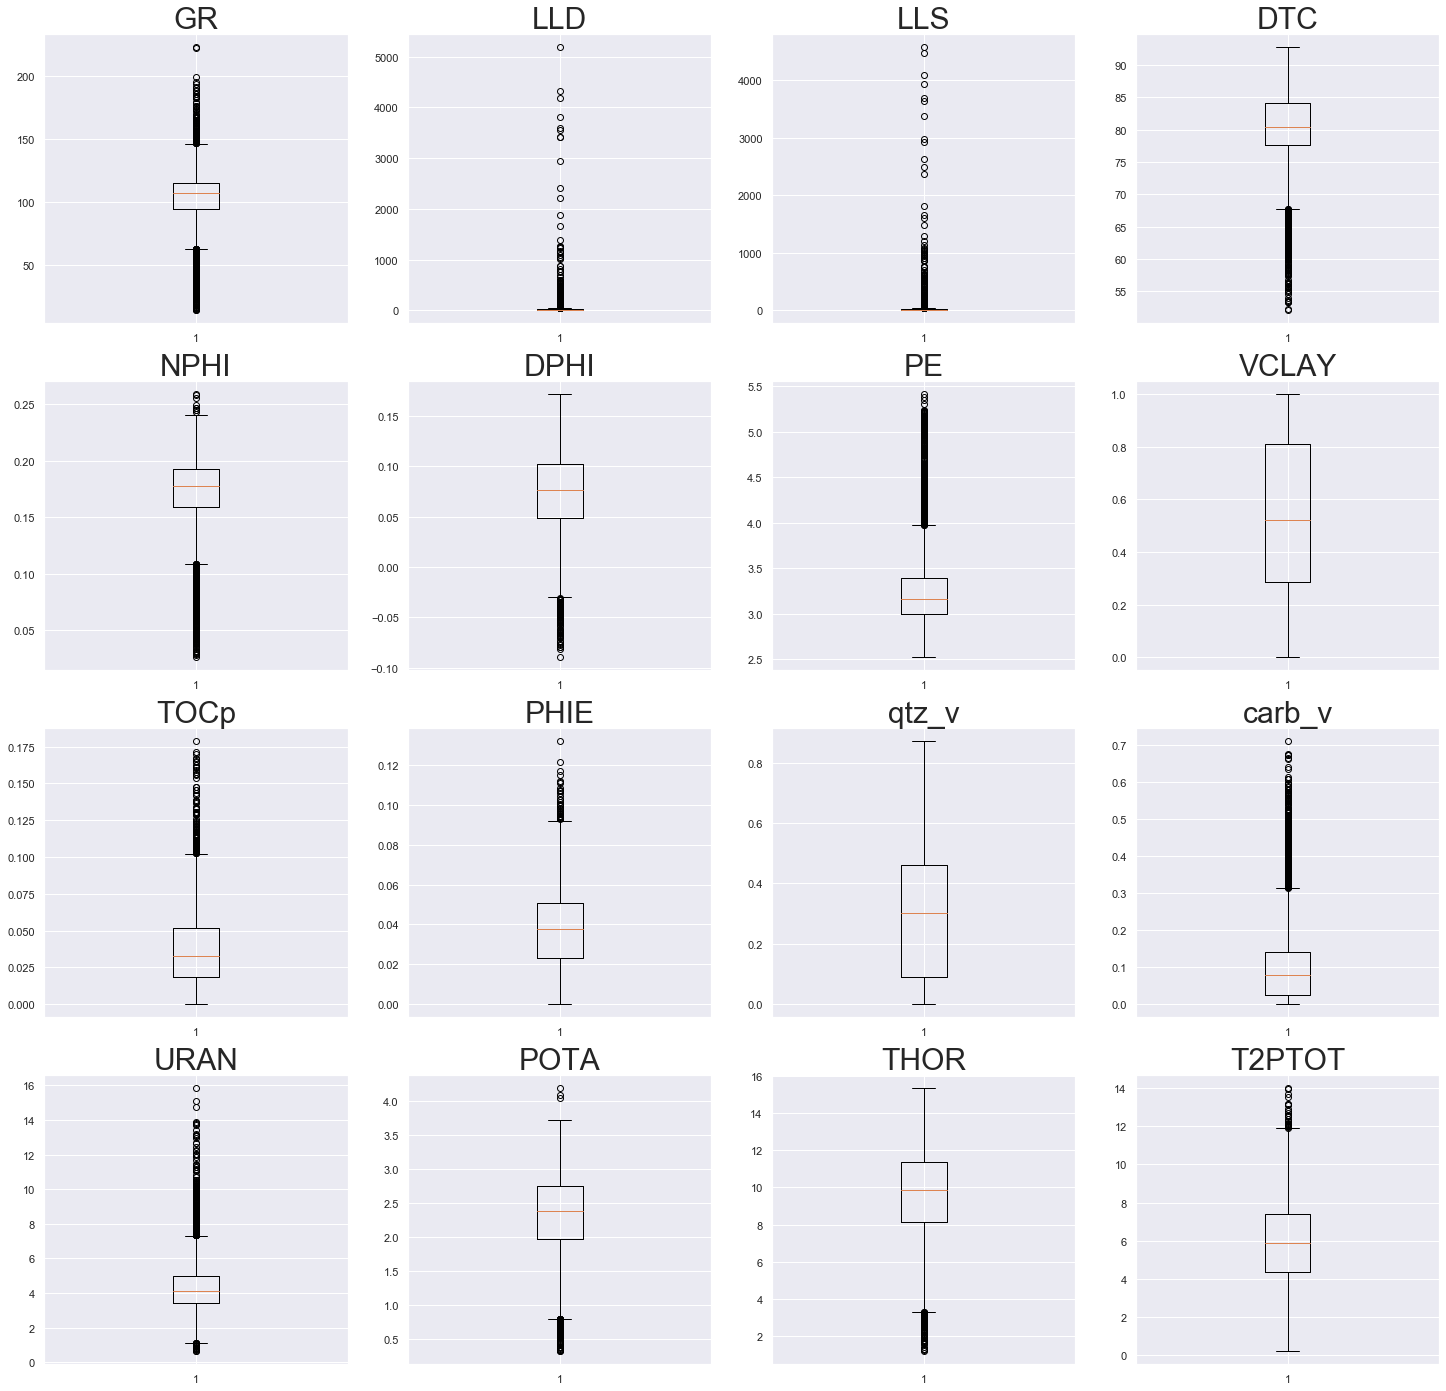

In [25]:
# Create Box Plots of new dataframe columns

plt.figure(figsize=(25,50))

for variable,i in dict.items():
                     plt.subplot(8,4,i)
                     plt.boxplot(df_var[variable])
                     plt.title(variable,fontsize=30)
                     

plt.show()

In [26]:
# Correlation plot showing DPHI, DTC, and NPHI have the stronges correlation to T2PTOT values

import seaborn as sns
num=df_var.select_dtypes(exclude='object')
numcorr=num.corr()
Num=numcorr['T2PTOT'].sort_values(ascending=False).head(50 ).to_frame()

cm = sns.light_palette("cyan", as_cmap=True)

s = Num.style.background_gradient(cmap=cm)
s

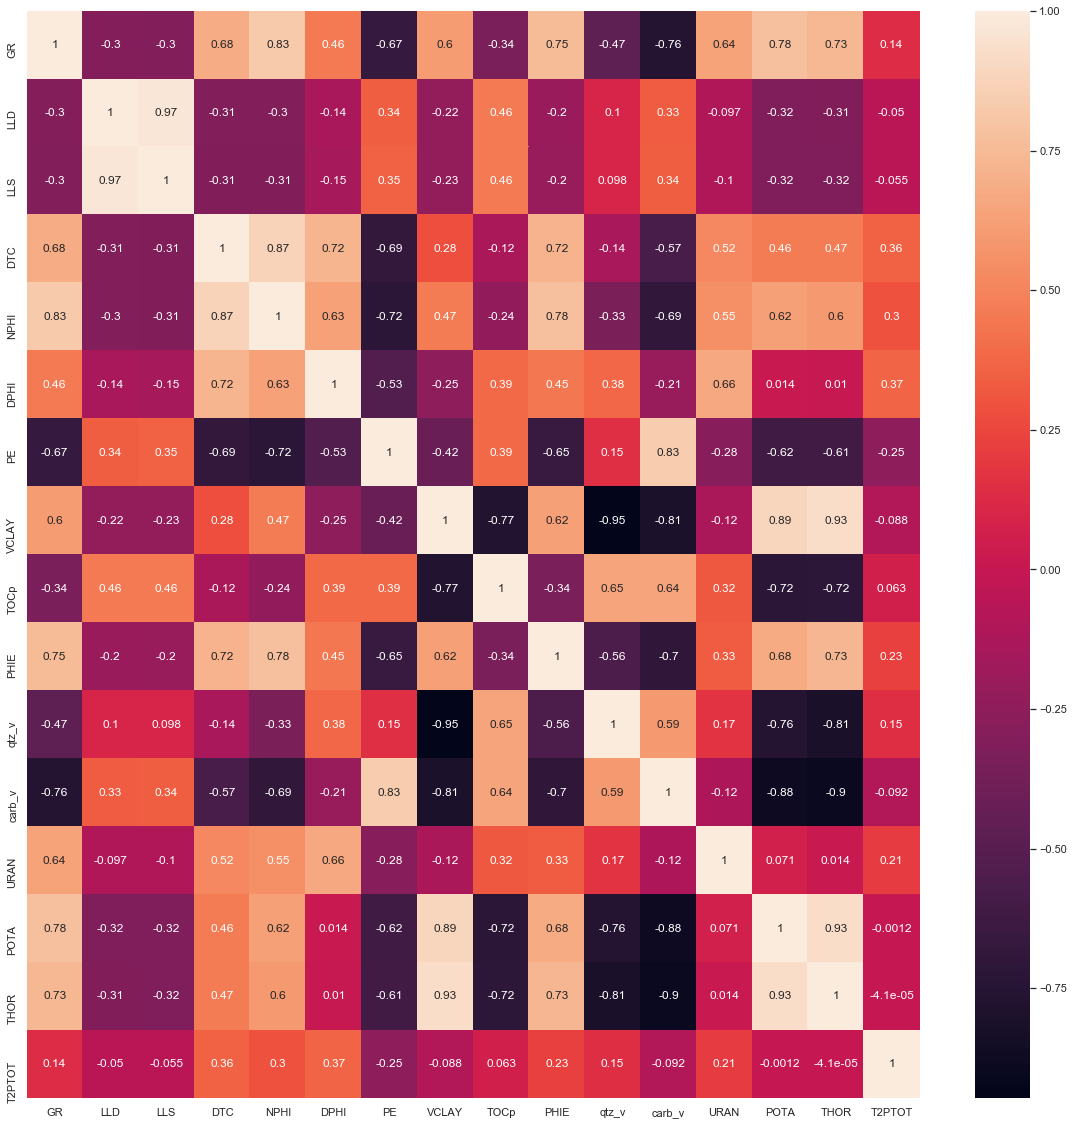

In [27]:
plt.figure(figsize=(20,20))
corrMatrix = df_var.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [28]:
# Create dummy columns for categorial variables (Litho)

df_var = pd.concat([df_var, pd.get_dummies(df_var['Litho'], drop_first=True)], axis=1)
df_var.head(10)

GR      LLD      LLS      DTC    NPHI    DPHI      PE     VCLAY  \
DEPT                                                                            
5999.5   83.1542  39.0576  39.2668  68.4340  0.1692  0.0385  3.7317  0.340519   
6000.0   51.8667  40.9065  65.7518  66.5135  0.1106 -0.0275  4.3621  0.168370   
6000.5   42.4689  22.8997  23.1424  66.0120  0.0827 -0.0555  4.6172  0.100177   
6001.0   54.7156  16.2764  15.5290  67.3842  0.0892 -0.0297  4.3662  0.115509   
6001.5   77.8558  13.3777  12.4495  71.3425  0.1211  0.0306  3.7084  0.153430   
6002.0   99.0742  13.7324  13.6269  75.9742  0.1669  0.0785  3.1376  0.238145   
6002.5  109.8616  17.1131  17.9738  79.7319  0.1960  0.0972  3.0561  0.355397   
6003.0  111.4397  17.1821  19.2843  81.4722  0.1955  0.1061  3.1799  0.368686   
6003.5  111.3080  16.6215  16.8260  82.4567  0.2015  0.1140  3.1276  0.383179   
6004.0  111.7202  16.8187  16.7018  82.2829  0.1963  0.1167  2.9516  0.352651   

            TOCp      PHIE     qtz_v    carb_v    URAN    POTA    THOR  \
DEPT                                                                     
5999.5  0.049053  0.013110  0.356595  0.240723  4.5539  1.6662  6.9042   
6000.0  0.039052  0.000000  0.360698  0.431880  3.1374  1.1808  4.8182   
6000.5  0.016999  0.000000  0.356264  0.526560  2.4591  0.9571  3.8050   
6001.0  0.013681  0.000000  0.426297  0.444512  2.8351  1.1207  4.3504   
6001.5  0.022160  0.004695  0.548477  0.271237  3.7476  1.4734  5.6445   
6002.0  0.032168  0.018694  0.561645  0.149347  4.7818  1.8458  7.0348   
6002.5  0.040080  0.034545  0.448663  0.121316  5.5811  2.1235  8.0671   
6003.0  0.042084  0.039118  0.418596  0.131516  5.8626  2.2670  8.5404   
6003.5  0.042659  0.043682  0.409615  0.120865  5.8688  2.3681  8.7870   
6004.0  0.043406  0.041154  0.464776  0.098013  5.6341  2.4004  8.8378   

        T2PTOT     Litho  OrgShale  Sand  Shale  
DEPT                                             
5999.5  6.8884  OrgShale         1     0      0  
6000.0  5.0732      Carb         0     0      0  
6000.5  3.7927      Carb         0     0      0  
6001.0  3.4217      Carb         0     0      0  
6001.5  3.8127      Carb         0     0      0  
6002.0  5.1398  OrgShale         1     0      0  
6002.5  6.4846  OrgShale         1     0      0  
6003.0  7.1212  OrgShale         1     0      0  
6003.5  6.6753  OrgShale         1     0      0  
6004.0  6.3261  OrgShale         1     0      0

# 6.  Creation and testing of ML models 
     1. Ordinary Least Squares
     2. LASSO Regression
     3. Ridge Regression
     4. ElasticNet Regression
     5. KNN-Neighbors
     6. Random Forest
     7. Gradient Boost 
`

In [29]:
# Define target (Y) and feature variables (X)

X = df_var.drop(columns = ["T2PTOT", "Litho"])
Y = df_var["T2PTOT"]

# Ordinary Least Squares

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

# We are making predictions here
results = sm.OLS(y_train, X_train).fit()
y_preds = results.predict(X_test)



print(results.summary())

The number of observations in training set is 4641
The number of observations in test set is 1161
R-squared of the model in the training set is: 0.21527132499330212
-----Test set statistics-----
R-squared of the model in the test set is: 0.1760679071944491
Mean absolute error of the prediction is: 1.5929669789866276
Mean squared error of the prediction is: 4.035782976939509
Root mean squared error of the prediction is: 2.0089258266395773
Mean absolute percentage error of the prediction is: 40.406139655043845
                            OLS Regression Results                            
Dep. Variable:                 T2PTOT   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     74.60
Date:                Tue, 11 Aug 2020   Prob (F-statistic):          5.43e-228
Time:                        15:27:47   Log-Likelihood:                -9716.5
No. Observat

#  LASSO Regression

In [31]:
lassoCV =LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
lassoCV.fit(X_train,y_train)

y_preds_train = lassoCV.predict(X_train)
y_preds_test = lassoCV.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoCV.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(lassoCV.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("The best alpha is: {}".format(lassoCV.alpha_))

R-squared of the model on the training set is: 0.20796714021000307
R-squared of the model on the test set is: 0.18139381264282695
Mean absolute error of the prediction is: 1.592850552076584
Mean squared error of the prediction is: 4.009695634629339
Root mean squared error of the prediction is: 2.0024224416015066
Mean absolute percentage error of the prediction is: 40.45700951724833
The best alpha is: 0.001


# Ridge Regression

In [32]:
ridgeCV = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
ridgeCV.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeCV.predict(X_train)
y_preds_test = ridgeCV.predict(X_test)

print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

print("R-squared of the model on the training set is: {}".format(ridgeCV.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(ridgeCV.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("The best alpha is: {}".format(ridgeCV.alpha_))

The number of observations in the training set is 4641
The number of observations in the test set is 1161
R-squared of the model on the training set is: 0.21525129813015387
R-squared of the model on the test set is: 0.1766676530114445
Mean absolute error of the prediction is: 1.592456757671729
Mean squared error of the prediction is: 4.03284530285222
Root mean squared error of the prediction is: 2.0081945380993895
Mean absolute percentage error of the prediction is: 40.387484642175586
The best alpha is: 0.01


# Elastic CV Regression

In [33]:


print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

# X_train = sm.add_constant(X_train)#This gives an error
alphas = [1e-3, 1e-2, 1e-1, 1]

elasticCV = ElasticNetCV(alphas=alphas,cv=5, random_state=0).fit(X_train, y_train)
elasticCV.fit(X_train, y_train)


# ridgeregr = Ridge(alpha=10) 
# ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticCV.predict(X_train)
y_preds_test = elasticCV.predict(X_test)


print("R-squared of the model on the training set is: {}".format(elasticCV.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(elasticCV.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("The best alpha is: {}".format(elasticCV.alpha_))

The number of observations in the training set is 4641
The number of observations in the test set is 1161
R-squared of the model on the training set is: 0.1941445356870921
R-squared of the model on the test set is: 0.17832214672544422
Mean absolute error of the prediction is: 1.5974565667510094
Mean squared error of the prediction is: 4.024741264152043
Root mean squared error of the prediction is: 2.0061757809703624
Mean absolute percentage error of the prediction is: 40.49339809841041
The best alpha is: 0.001


# KNN Neighbors Regressor

In [34]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)

knn_y_preds_train = knn.predict(X_train)
knn_y_preds_test = knn.predict(X_test)

from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(knn, X, Y, cv=5)

print("R-squared of the model on the training set is: {}".format(knn.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(knn.score(X_test, y_test)))
# print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), score.std() * 2))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, knn_y_preds_test)))#this is not working


# score_w = cross_val_score(knn, X, Y, cv=5)
# print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

R-squared of the model on the training set is: 1.0
R-squared of the model on the test set is: 0.1790724714457429
Root mean squared error of the prediction is: 2.005259590352309


# Gradient Boosting Regressor

In [35]:
# Perform GridSearch CV to tune hyperparameters (commented out because it takes a while to run)

# param_grid = { 
#     'n_estimators': [100,200],'learning_rate':[.01,.001], 'min_samples_split':[500,750],'min_samples_leaf':[5,10],
#     'max_features': ['auto'],
#     'max_depth' : [30,40]}

# gb_regressor =GradientBoostingRegressor(random_state = 42)

# CV_gbr = GridSearchCV(estimator=gb_regressor,param_grid= param_grid, cv= 5)
# CV_gbr.fit(X_train, y_train)

# print(CV_gbr.best_params_)


In [36]:
params = {'n_estimators': 200,
          'max_depth': 10,#changed from 20 for speed
          'min_samples_split': 500,
          'learning_rate': 0.01,
          'loss': 'ls'}
# Initialize and fit the model.
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)

gbr_predict_train = gbr.predict(X_train)
gbr_predict_test = gbr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(gbr.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(gbr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, gbr_predict_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, gbr_predict_test)))
print("Root mean squared error of the test set prediction is: {}".format(rmse(y_test, gbr_predict_test)))
print("Root mean squared error of the training set prediction is: {}".format(rmse(y_train, gbr_predict_train)))#

R-squared of the model on the training set is: 0.35206515478218714
R-squared of the model on the test set is: 0.2501969710531353
Mean absolute error of the prediction is: 1.525521317315124
Mean squared error of the prediction is: 3.672684104314393
Root mean squared error of the test set prediction is: 1.9164248235488897
Root mean squared error of the training set prediction is: 1.7841061430918288


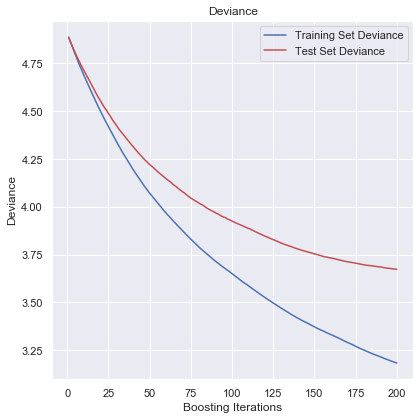

In [37]:
# Plot to view model deviance to boosting iterations

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Feature Importance (MDI)')

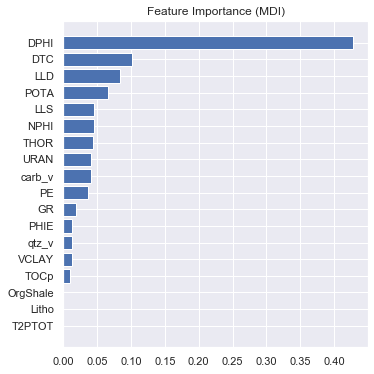

In [38]:
# Plot of feature importance.  Note DPHI has greates predictive power on T2PTOT

feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df_var.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')


# Random Forest Regressor

In [39]:


# Inital Random Forest Model with default hyperparamters 

regressor = RandomForestRegressor(n_estimators = 10, random_state = 222)

regressor.fit(X_train, y_train)

# We are making predictions here
y_preds_train = regressor.predict(X_train)
y_preds_test = regressor.predict(X_test)


print("R-squared of the model on the training set is: {}".format(regressor.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(regressor.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



R-squared of the model on the training set is: 0.8818924230086918
R-squared of the model on the test set is: 0.3352159540581189
Mean absolute error of the prediction is: 1.4266612754809074
Mean squared error of the prediction is: 3.2562442455878338
Root mean squared error of the prediction is: 1.8045066488067685
Mean absolute percentage error of the prediction is: 34.294963206031554


In [40]:
# Perform GridSearch CV to tune hyperparameters of Random Forest Model 


# param_grid = { 
#     'n_estimators': [300,400],
#     'max_features': [5,10],
#     'max_depth' : [20,30]}

# CV_rfc = GridSearchCV(estimator=regressor, param_grid= param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)

# print(CV_rfc.best_params_)

In [41]:
# Tuned Random Forest model using hyperparamters from GridSearchCV above

rfcv=RandomForestRegressor(random_state=42, max_features='auto', n_estimators= 400, max_depth=20,)
rfcv.fit(X_train, y_train)


rfcv_predict_train = rfcv.predict(X_train)
rfcv_predict_test = rfcv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(rfcv.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(rfcv.score(X_test, y_test)))

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, rfcv_predict_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, rfcv_predict_test)))
print("Root mean squared error of the test set prediction is: {}".format(rmse(y_test, rfcv_predict_test)))
print("Root mean squared error of the training set prediction is: {}".format(rmse(y_train, rfcv_predict_train)))

R-squared of the model on the training set is: 0.9064954920287708
R-squared of the model on the test set is: 0.3903420568858705
Mean absolute error of the prediction is: 1.3698353501864171
Mean squared error of the prediction is: 2.9862256490070087
Root mean squared error of the test set prediction is: 1.728069920173084
Root mean squared error of the training set prediction is: 0.6777527602831022


# 7.  Tuning of Random Forest model to resolve overfitting 

In [42]:
# Final Random Forest Model adjusted to avoid overfitting: Lower max_features, higher n_estimators,lower max_depth

rfcv2=RandomForestRegressor(random_state=42, max_features=5, n_estimators= 1000, max_depth=10,)
rfcv2.fit(X_train, y_train)


rfcv2_predict_train = rfcv2.predict(X_train)
rfcv2_predict_test = rfcv2.predict(X_test)

print("R-squared of the model on the training set is: {}".format(rfcv2.score(X_train, y_train)))
print("R-squared of the model on the test set is: {}".format(rfcv2.score(X_test, y_test)))

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, rfcv2_predict_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, rfcv2_predict_test)))
print("Root mean squared error of the test set prediction is: {}".format(rmse(y_test, rfcv2_predict_test)))
print("Root mean squared error of the training set prediction is: {}".format(rmse(y_train, rfcv2_predict_train)))

R-squared of the model on the training set is: 0.6124392438094222
R-squared of the model on the test set is: 0.3210716907173631
Mean absolute error of the prediction is: 1.448463747640354
Mean squared error of the prediction is: 3.3255256556826867
Root mean squared error of the test set prediction is: 1.823602384206241
Root mean squared error of the training set prediction is: 1.379827885965523


In [43]:
# gbr.fit(X,Y)
# predictions = gbr.predict(X)

# 8.  Final comparison and model selection

(4641,)
(1161,)


<function matplotlib.pyplot.show(*args, **kw)>

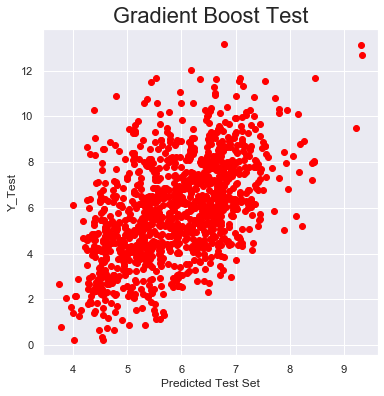

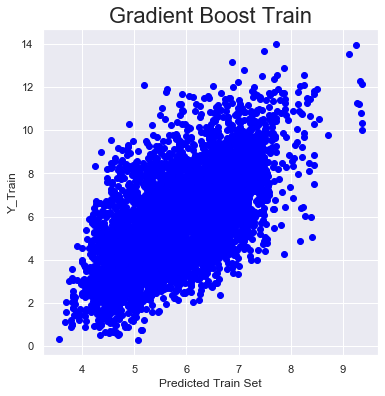

In [44]:
model_gbr = gbr.predict(X)
# do on training and test set separately. Plot X_Train against y_train, and X_test aganist y_test
train_gbr = gbr.predict(X_train)
test_gbr = gbr.predict(X_test)
print(train_gbr.shape)
print(test_gbr.shape)

depth = np.array(df_var.index)

fig = plt.figure(figsize=(6,6))
plt.title('Gradient Boost Test',fontsize=22)
plt.plot(figsize=(40,40), linewidth=.5)
plt.scatter(test_gbr, y_test, c='red')
plt.xlabel('Predicted Test Set')
plt.ylabel('Y_Test')

plt.show

fig = plt.figure(figsize=(6,6))
plt.title('Gradient Boost Train',fontsize=22)
plt.plot(figsize=(40,40), linewidth=.5)
plt.scatter(train_gbr, y_train, c='blue')
plt.xlabel('Predicted Train Set')
plt.ylabel('Y_Train')
# plt.plot(depth, )

plt.show



In [45]:

# y_test['new_idx'] = range(1, len(y_test) )
# y_test = y_test.drop(['new_idx'])
# # y_test

<function matplotlib.pyplot.show(*args, **kw)>

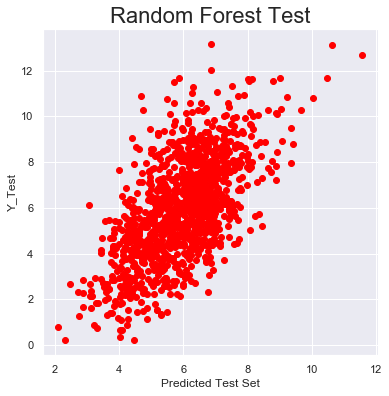

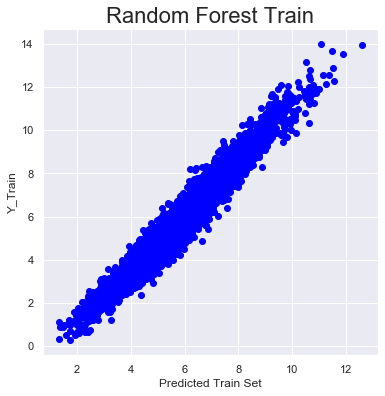

In [46]:

# Random Forest Train/Test Scatter Plot.  Note significant overfitting of Training Set. 
model_rfcv = rfcv.predict(X)
train_rfcv = rfcv.predict(X_train)
test_rfcv = rfcv.predict(X_test)

depth = np.array(df_var.index)

fig = plt.figure(figsize=(6,6))
plt.title('Random Forest Test',fontsize=22)
plt.plot(figsize=(40,40), linewidth=.5)
plt.scatter(test_rfcv, y_test, c='red')
plt.xlabel('Predicted Test Set')
plt.ylabel('Y_Test')
# plt.plot(depth, )

plt.show

fig = plt.figure(figsize=(6,6))
plt.title('Random Forest Train',fontsize=22)
plt.plot(figsize=(40,40), linewidth=.5)
plt.scatter(train_rfcv, y_train, c='blue')
plt.xlabel('Predicted Train Set')
plt.ylabel('Y_Train')
# plt.plot(depth, )

plt.show


<function matplotlib.pyplot.show(*args, **kw)>

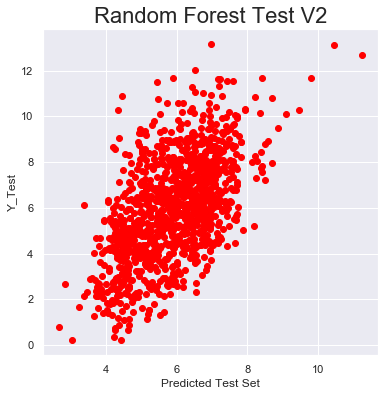

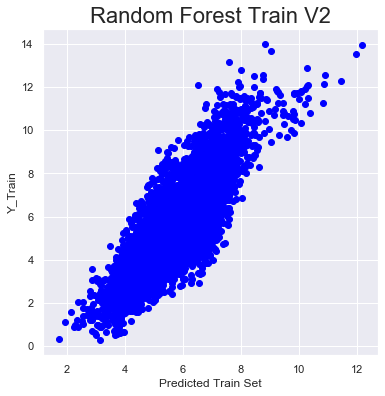

In [47]:
# Scatter plot of Random Forest Version 2, with reduced hyperparameters to combat overfitting

model_rfcv2 = rfcv2.predict(X)
train_rfcv2 = rfcv2.predict(X_train)
test_rfcv2 = rfcv2.predict(X_test)

fig = plt.figure(figsize=(6,6))
plt.title('Random Forest Test V2',fontsize=22)
plt.plot(figsize=(40,40), linewidth=.5)
plt.scatter(test_rfcv2, y_test, c='red')
plt.xlabel('Predicted Test Set')
plt.ylabel('Y_Test')
# plt.plot(depth, )

plt.show

fig = plt.figure(figsize=(6,6))
plt.title('Random Forest Train V2',fontsize=22)
plt.plot(figsize=(40,40), linewidth=.5)
plt.scatter(train_rfcv2, y_train, c='blue')
plt.xlabel('Predicted Train Set')
plt.ylabel('Y_Train')
# plt.plot(depth, )

plt.show

In [48]:
# create dataframes of Random Forest and Gradient Boost models to merge to final dataframe

model_df =pd.DataFrame(model_rfcv, columns = ["model_rfcv"], index = df_var.index)
model_df2 =pd.DataFrame(model_gbr,columns = ["model_gbr"], index = df_var.index)
model_df3 =pd.DataFrame(model_rfcv2, columns = ["model_rfcv2"], index = df_var.index)

In [49]:
df_all['DEPTH'] = df_all.index
df_all=df_all.drop(columns=["DEPTH","DEPT"])

In [50]:
df_all = pd.merge(df_all, model_df,on = "DEPT")
df_all = pd.merge(df_all, model_df2,on = "DEPT")
df_all = pd.merge(df_all, model_df3,on = "DEPT")


In [51]:
# Rename columns to remove whitespace
df_all.columns = df_all.columns.str.strip().str.upper().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [52]:
# Create Depth index
df_all['DEPTH'] = df_all.index

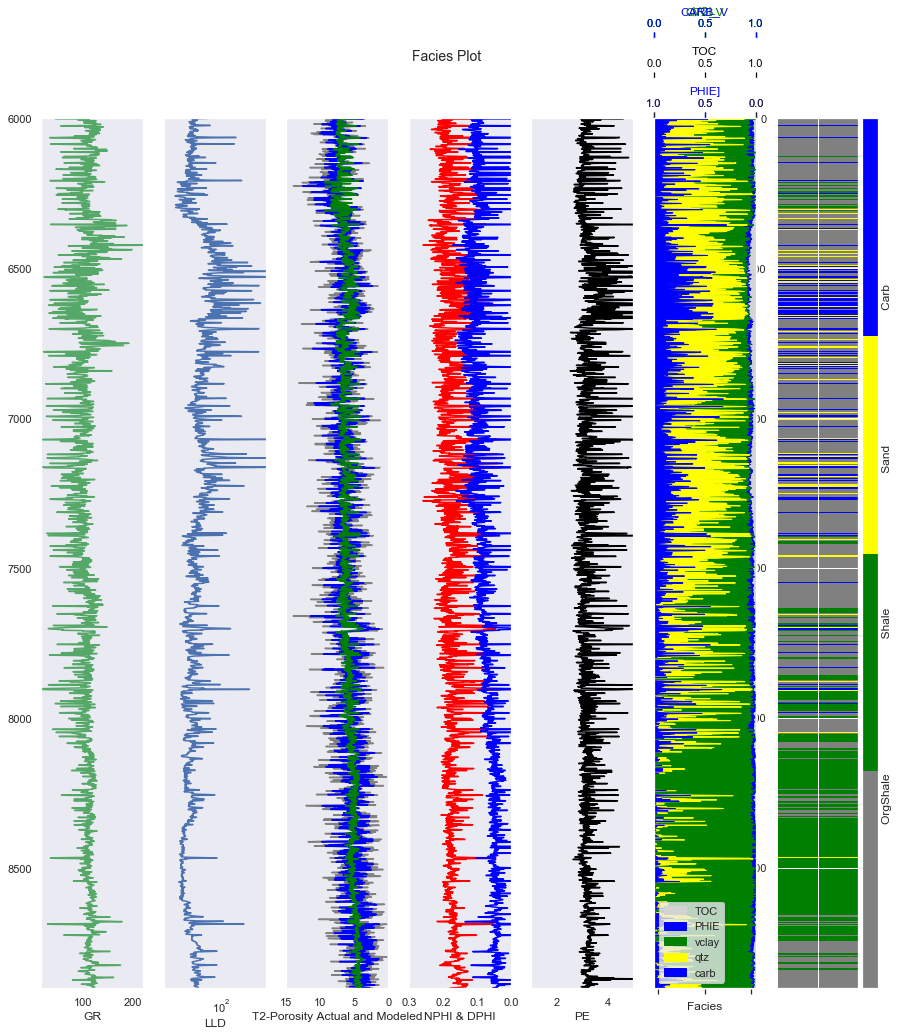

In [53]:
logs = df_all.copy()
def make_facies_log_plot(df_all, facies_colors):
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPTH.min(); zbot=logs.DEPTH.max()
    
    cluster=np.repeat(np.expand_dims(df_all['LITHO_VALUES'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(15, 16))
    ax[0].plot(df_all.GR, df_all.DEPTH, '-g')
    ax[1].plot(df_all.LLD, df_all.DEPTH, '-')
    ax[2].plot(df_all.T2PTOT, df_all.DEPTH, '-', color='gray')
    ax[2].plot(df_all.MODEL_RFCV, df_all.DEPTH, '-', color='blue')
    ax[2].plot(df_all.MODEL_GBR, df_all.DEPTH, '-', color='green')
    ax[3].plot(df_all.NPHI, df_all.DEPTH, '-', color='red')
    ax[3].plot(df_all.DPHI, df_all.DEPTH, '-', color='blue')
    ax[4].plot(df_all.PE, df_all.DEPTH, '-', color='black')
    im=ax[6].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=5)
    
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((40*' ').join(['OrgShale', 'Shale', 'Sand', 'Carb']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(df_all.GR.min(),df_all.GR.max())
    ax[1].set_xlabel("LLD")
    ax[1].set_xscale('log')
    ax[1].set_xlim(2,2000)
    ax[2].set_xlabel("T2-Porosity Actual and Modeled")
    ax[2].set_xlim(15, 0)
    ax[3].set_xlabel("NPHI & DPHI")
    ax[3].set_xlim(0.3, 0)
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(1,5)
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([]);ax[6].set_xticklabels([])
    f.suptitle('Facies Plot', fontsize=14,y=0.94)
    
#Mineralogy plot

    ax50=ax[5].twiny()
    ax50.set_xlim(1,0)
    ax50.spines['top'].set_position(('outward',0))
    ax50.plot(df_all.PHIE, df_all.DEPTH, label='PHIE', color='black',linewidth=0.5)
    ax50.set_xlabel('PHIE]', color='blue')    
    ax50.tick_params(axis='x', colors='blue')

    ax51=ax[5].twiny()
    ax51.set_xlim(0,1)
    ax51.spines['top'].set_position(('outward',40))
    ax51.plot(df_all.TOCP, df_all.DEPTH, label='TOC', color='black',linewidth=0.5)
    ax51.set_xlabel('TOC', color='black')    
    ax51.tick_params(axis='x', colors='black')

    ax52=ax[5].twiny()
    ax52.set_xlim(0,1)
    ax52.spines['top'].set_position(('outward',80))
    ax52.plot(df_all.VCLAY, df_all.DEPTH, label='VCL', color='green',linewidth=0.5)
    ax52.set_xlabel('VCL', color='green')    
    ax52.tick_params(axis='x', colors='green')

    ax53=ax[5].twiny()
    ax53.set_xlim(0,1)
    ax53.spines['top'].set_position(('outward',80))
    ax53.plot(df_all.QTZ_V, df_all.DEPTH, label='QTZ_V', color='green',linewidth=0.5)
    ax53.set_xlabel('QTZ_V', color='green')    
    ax53.tick_params(axis='x', colors='green')

    ax53=ax[5].twiny()
    ax53.set_xlim(0,1)
    ax53.spines['top'].set_position(('outward',80))
    ax53.plot(df_all.CARB_V, df_all.DEPTH, label='CARB_V', color='blue',linewidth=0.5)
    ax53.set_xlabel('CARB_V', color='blue')    
    ax53.tick_params(axis='x', colors='blue')

    df_all["disp_phie"] = df_all["TOCP"] + df_all["PHIE"]
    df_all["disp_vcl"] = df_all["TOCP"] + df_all["PHIE"] + df_all["VCLAY"]
    df_all["disp_qtz"]= df_all["TOCP"] + df_all["PHIE"] + df_all["VCLAY"] + df_all["QTZ_V"]

    ax52=ax[5].twiny()
    ax52.set_xlim(1,0)
    ax52.spines['top'].set_position(('outward',0))
    ax52.fill_betweenx(df_all.DEPTH,0,df_all.TOCP,color='lightgray',label='TOC')
    ax52.fill_betweenx(df_all.DEPTH,df_all.TOCP,df_all.disp_phie, color='blue',label='PHIE')
    ax52.fill_betweenx(df_all.DEPTH,df_all.disp_phie,df_all.disp_vcl,color='green',label='vclay')
    ax52.fill_betweenx(df_all.DEPTH,df_all.disp_vcl,df_all.disp_qtz,color='yellow',label='qtz')                                    
    ax52.fill_betweenx(df_all.DEPTH,df_all.disp_qtz,1,color='blue',label='carb') 
    ax52.legend(loc='lower left')


make_facies_log_plot(logs,facies_colors)

None


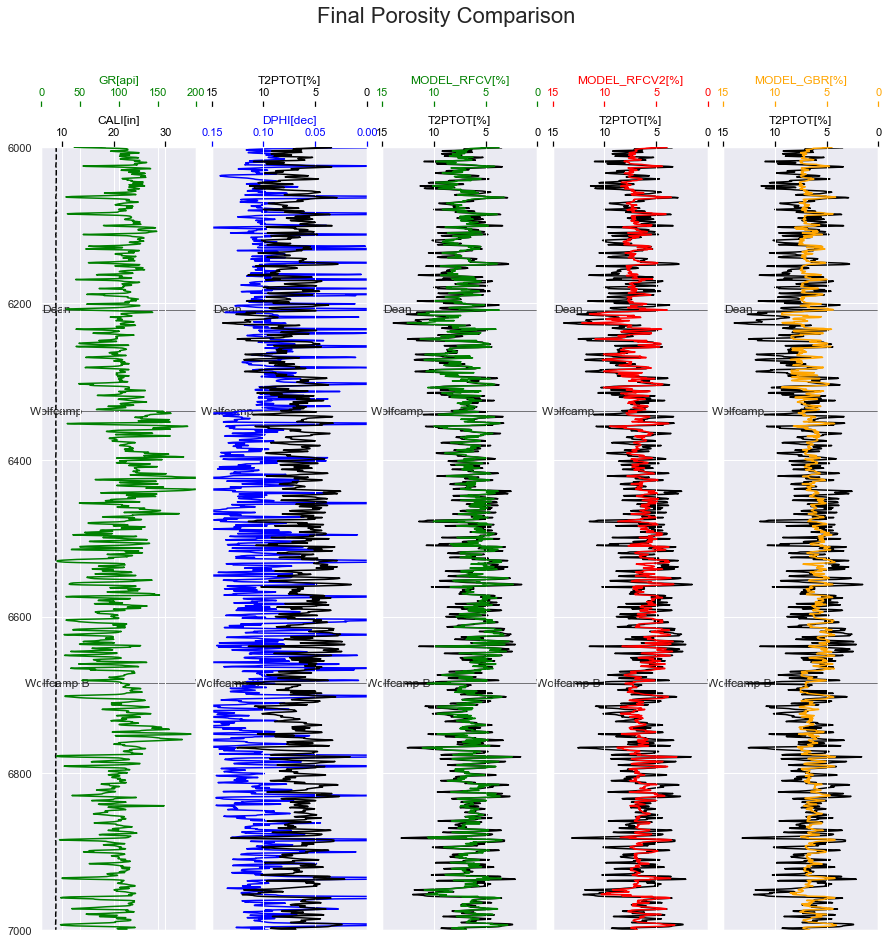

In [54]:
def triple_combo_plot(top_depth,bottom_depth):
    
    logs=df_all[(df_all.DEPTH >= top_depth) & (df_all.DEPTH <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15), sharey=True)
    fig.suptitle("Final Porosity Comparison", fontsize=22)
    fig.subplots_adjust(top=.85,wspace=0.1)

#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(tops_depths,tops):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
    
        
#1st track: GR and CALI
    
    ax02=ax[0].twiny()
    ax02.set_xlim(6,36)
    ax02.plot(df_all.CALI, df_all.DEPTH, '--', label='CALN[in]', color='black') 
    ax02.spines['top'].set_position(('outward',0))
    ax02.set_xlabel('CALI[in]',color='black')    
    ax02.tick_params(axis='x', colors='black')
    
    ax03=ax[0].twiny()
    ax03.set_xlim(0,200)
    ax03.plot(df_all.GR, df_all.DEPTH, label='GR[api]', color='green') 
    ax03.spines['top'].set_position(('outward',40))
    ax03.set_xlabel('GR[api]',color='green')    
    ax03.tick_params(axis='x', colors='green')


#2nd track: T2PTOT and DPHI 
    
    
    ax11=ax[1].twiny()
    ax11.set_xlim(.15,0)
    ax11.plot(df_all.DPHI, df_all.DEPTH ,label='DPHI[dec]', color='blue') 
    ax11.spines['top'].set_position(('outward',0))
    ax11.set_xlabel('DPHI[dec]',color='blue')
    ax11.tick_params(axis='x', colors='blue')
    
    ax12=ax[1].twiny()
    ax12.grid(True)
    ax12.set_xlim(15,0)
    ax12.spines['top'].set_position(('outward',40))
    ax12.set_xlabel('T2PTOT[%]')
    ax12.plot(df_all.T2PTOT, df_all.DEPTH, label='T2PTOT[%]', color='black')
    ax12.set_xlabel('T2PTOT[%]', color='black')    
    ax12.tick_params(axis='x', colors='black')
    
    
#3rd track: T2PTOT and Modeled RFCV
    
    ax21=ax[2].twiny()
    ax21.grid(True)
    ax21.set_xlim(15,0)
    ax21.spines['top'].set_position(('outward',0))
    ax21.set_xlabel('T2PTOT[%]')
    ax21.plot(df_all.T2PTOT, df_all.DEPTH, label='T2PTOT[%]', color='black')
    ax21.set_xlabel('T2PTOT[%]', color='black')    
    ax21.tick_params(axis='x', colors='black')
    
    ax22=ax[2].twiny()
    ax22.set_xlim(15,0)
    ax22.plot(df_all.MODEL_RFCV, df_all.DEPTH, label='MODEL_RFCV[%]', color='green') 
    ax22.spines['top'].set_position(('outward',40))
    ax22.set_xlabel('MODEL_RFCV[%]', color='green')    
    ax22.tick_params(axis='x', colors='green')
    
    
#4th track: T2PTOT and Modeled GBR
    ax31=ax[3].twiny()
    ax31.grid(True)
    ax31.set_xlim(15,0)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel('T2PTOT[%]')
    ax31.plot(df_all.T2PTOT, df_all.DEPTH, label='T2PTOT[%]', color='black')
    ax31.set_xlabel('T2PTOT[%]', color='black')    
    ax31.tick_params(axis='x', colors='black')
     
    ax32=ax[3].twiny()
    ax32.set_xlim(15,0)
    ax32.plot(df_all.MODEL_RFCV2, df_all.DEPTH ,label='MODEL_RFCV2[%]', color='red') 
    ax32.spines['top'].set_position(('outward',40))
    ax32.set_xlabel('MODEL_RFCV2[%]',color='red')
    ax32.tick_params(axis='x', colors='red')
   
    #plt.savefig ('triple_combo_plot.png', dpi=200, format='png')
    
#5th track: T2PTOT and Modeled GBR
    ax31=ax[4].twiny()
    ax31.grid(True)
    ax31.set_xlim(15,0)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel('T2PTOT[%]')
    ax31.plot(df_all.T2PTOT, df_all.DEPTH, label='T2PTOT[%]', color='black')
    ax31.set_xlabel('T2PTOT[%]', color='black')    
    ax31.tick_params(axis='x', colors='black')
     
    ax32=ax[4].twiny()
    ax32.set_xlim(15,0)
    ax32.plot(df_all.MODEL_GBR, df_all.DEPTH ,label='MODEL_GBR[%]', color='orange') 
    ax32.spines['top'].set_position(('outward',40))
    ax32.set_xlabel('MODEL_GBR[%]',color='orange')
    ax32.tick_params(axis='x', colors='orange')

    #plt.savefig ('triple_combo_plot.png', dpi=200, format='png')
top_depth = 6000
bottom_depth = 7000
print(triple_combo_plot(top_depth, bottom_depth))

# Summary of Results
NMR-Derived Porosity was modeled using machine learning from 10 delivered feature variables, 5 calculated numeric variables  and 4 categorial variables.  The best performing models were Random Forest and Gradient Boost algorithms. Maximizing fit using GridSearchCV resulted in adequate performance using Gradient Boost and significant overfitting for Random Forest models. A more reasonable Random Forest model was created using adjusted hyperparamters and performs well across high and low nmr-derived porosity values. RMSE values for the final Random Forest model of of 1.83-1.36 (%, test-train) for predicted NMR-derived porosity values are a significant improvement over DPHI, NPHI, and PHIE values, and indicate using ML to model more expensive logging deliverables, like T2PTOT, is a useful workflow and worthy of expansion over a larger area/dataset.  
